In [68]:
import pandas as pd
import numpy as np
from sklearn.manifold import Isomap, LocallyLinearEmbedding
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [69]:
# `from google.colab import drive
# drive.mount('/content/drive')


In [70]:
import pandas as pd

# 파일 경로 설정 (드라이브 경로)
file_path = 'Q_df.txt'

# 파일 읽기
df = pd.read_csv(file_path)


## 1-1 X, Y 변수 정의

In [71]:
import pandas as pd

missing_count = df.isnull().sum()
missing_value_rank = missing_count.sort_values(ascending=False)
missing_value_rank
df = df.dropna(axis=1, how='any')

# 열 이름들을 리스트로 추출
columns = df.columns


y_vars = [
    "3SIGX", "3SIGY", "AVRX", "AVRX+3SIGX", "AVRY", "AVRY+3SIGY", "IROT",
    "Q_OUT_3SIG_X", "Q_OUT_3SIG_Y", "Q_OUT_AVG_X", "Q_OUT_AVG_Y", "RSDX", "RSDY",
    "TIS3SIGX", "TIS3SIGY", "TISAVRX", "TISAVRX+3SIGX", "TISAVRY", "TISAVRY+3SIGY",
    "TISMAXX", "TISMAXX_D", "TISMAXY", "TISMAXY_D", "TISMINX", "TISMINX_D", "TISMINY", "TISMINY_D"
]

# avg와 MI가 포함된 x 변수 식별
x_avg_vars = [col for col in columns if 'avg' in col.lower() and 'AMAT' not in col and col not in y_vars]
x_mi_vars = [col for col in columns if 'MI' in col and col not in y_vars]
x_cmp_vars = [col for col in columns if 'AMAT' in col or 'TIME' in col and not df[col].isnull().any()]
elements_to_remove = ['AMAT_HEAD_NO','HEAD1_TIME','HEAD2_TIME','HEAD3_TIME','P2_TIME']
x_cmp_vars = [col for col in x_cmp_vars if col not in elements_to_remove]

# L, R, T, B로 끝나는 변수 식별
x_l_vars = [col for col in columns if col.endswith('L') and col not in y_vars]
x_r_vars = [col for col in columns if col.endswith('R') and col not in y_vars]
x_t_vars = [col for col in columns if col.endswith('T') and col not in y_vars]
x_b_vars = [col for col in columns if col.endswith('B') and col not in y_vars]

# SLOPE, GAP, BOX, SLP를 포함한 변수 식별
x_slope_vars = [col for col in columns if 'SLOPE' in col and col not in y_vars]
x_gap_vars = [col for col in columns if 'GAP' in col and col not in y_vars]
x_box_vars = [col for col in columns if 'BOX' in col and col not in y_vars]
x_slp_vars = [col for col in columns if 'SLP' in col and col not in y_vars]

# 변수 정의
x_variables = {
    "x_avg_vars": x_avg_vars,
    "x_mi_vars": x_mi_vars,
    "x_l_vars": x_l_vars,
    "x_r_vars": x_r_vars,
    "x_t_vars": x_t_vars,
    "x_b_vars": x_b_vars,
    "x_slope_vars": x_slope_vars,
    "x_gap_vars": x_gap_vars,
    "x_box_vars": x_box_vars,
    "x_slp_vars": x_slp_vars
}

# 결과 출력
print(f"avg가 포함된 변수: {len(x_avg_vars)}개")
print(f"cmp src 변수: {len(x_cmp_vars)}개")
print(f"MI가 포함된 변수: {len(x_mi_vars)}개")
print(f"L로 끝나는 변수: {len(x_l_vars)}개")
print(f"R로 끝나는 변수: {len(x_r_vars)}개")
print(f"T로 끝나는 변수: {len(x_t_vars)}개")
print(f"B로 끝나는 변수: {len(x_b_vars)}개")
print(f"SLOPE가 포함된 변수: {len(x_slope_vars)}개")
print(f"GAP가 포함된 변수: {len(x_gap_vars)}개")
print(f"BOX가 포함된 변수: {len(x_box_vars)}개")
print(f"SLP가 포함된 변수: {len(x_slp_vars)}개")




avg가 포함된 변수: 44개
cmp src 변수: 5개
MI가 포함된 변수: 28개
L로 끝나는 변수: 4개
R로 끝나는 변수: 4개
T로 끝나는 변수: 4개
B로 끝나는 변수: 4개
SLOPE가 포함된 변수: 42개
GAP가 포함된 변수: 28개
BOX가 포함된 변수: 14개
SLP가 포함된 변수: 16개


## ***** 스케일링 여부 *****

In [72]:
from sklearn.preprocessing import StandardScaler
# 스케일링 여부 선택
scaling_choice = input("변수 스케일링 여부를 선택하세요 (Y/N): ")

if scaling_choice.upper() == 'Y':
    # 스케일링할 변수들 모두 선택
    scaling_vars = x_avg_vars + x_mi_vars + x_l_vars + x_r_vars + x_t_vars + x_b_vars + x_slope_vars + x_gap_vars + x_box_vars + x_slp_vars
    scaler = StandardScaler()
    df[scaling_vars] = scaler.fit_transform(df[scaling_vars])
    print("변수 스케일링을 완료했습니다.")
elif scaling_choice.upper() == 'N':
    print("변수 스케일링을 하지 않았습니다.")
else:
    print("잘못된 입력입니다. 스케일링을 하지 않았습니다.")

변수 스케일링을 완료했습니다.


## 1-2. 중복 행 제거 (Q_OUT_3SIG_X, Q_OUT_3SIG_Y 동일할 경우 기준)

In [73]:
import pandas as pd

# 가정: df가 이미 존재하며, 모든 필요한 변수가 포함되어 있다고 가정합니다.

# y 변수 리스트
y_vars = [
    "3SIGX", "3SIGY", "AVRX", "AVRX+3SIGX", "AVRY", "AVRY+3SIGY", "IROT",
    "Q_OUT_3SIG_X", "Q_OUT_3SIG_Y", "Q_OUT_AVG_X", "Q_OUT_AVG_Y", "RSDX", "RSDY",
    "TIS3SIGX", "TIS3SIGY", "TISAVRX", "TISAVRX+3SIGX", "TISAVRY", "TISAVRY+3SIGY",
    "TISMAXX", "TISMAXX_D", "TISMAXY", "TISMAXY_D", "TISMINX", "TISMINX_D", "TISMINY", "TISMINY_D"
]

# x 변수 리스트를 정의하는 부분은 여기서 생략하고, x 변수 리스트가 이미 정의되었다고 가정합니다.
# independent_vars에는 모든 필요한 x 변수가 포함되어 있다고 가정합니다.
independent_vars = x_avg_vars + x_mi_vars + x_l_vars + x_r_vars + x_t_vars + x_b_vars + x_slope_vars + x_gap_vars + x_box_vars + x_slp_vars + x_cmp_vars

# 중복된 행을 제거하는 기준 변수 설정
# 여기서는 'Q_OUT_3SIG_X'와 'Q_OUT_AVG_X' 열을 기준으로 중복을 제거합니다.
dedup_columns = ['Q_OUT_3SIG_X', 'Q_OUT_AVG_X']

# 중복 제거
df_dedup = df.drop_duplicates(subset=dedup_columns)

# 필요한 컬럼만 선택하여 최종 DataFrame 생성
final_columns = independent_vars + y_vars
df_del_row = df_dedup[final_columns].dropna()
df = df_del_row.reset_index()

# 결과 확인
print(df_del_row.info())

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 170498
Columns: 220 entries, BOTTOM_BOX_AVG to TISMINY_D
dtypes: float64(220)
memory usage: 297.0 KB
None


In [74]:
df

,index,BOTTOM_BOX_AVG,BOTTOM_GAP_AVG,BOTTOM_GAP_V_AVG,BOTTOM_SLOPE_ALL_AVG,BOTTOM_SLOPE_B_AVG,BOTTOM_SLOPE_L_AVG,BOTTOM_SLOPE_R_AVG,BOTTOM_SLOPE_T_AVG,BOX_AVG,...,TISAVRY,TISAVRY+3SIGY,TISMAXX,TISMAXX_D,TISMAXY,TISMAXY_D,TISMINX,TISMINX_D,TISMINY,TISMINY_D
0,0,-1.231521,0.487130,0.839975,-1.632587,-1.422965,-1.197450,-0.701615,-1.222878,0.068802,...,0.618,1.023,0.993672,0.373109,0.909031,0.290888,0.282793,-0.337770,0.255067,-0.363076
1,942,1.073195,-1.187669,-0.500622,0.412411,0.973722,-0.260102,0.538913,-0.130137,0.926263,...,0.756,1.220,0.950438,0.377802,1.259040,0.502853,0.251607,-0.321029,0.454161,-0.302026
2,1884,-0.169971,-1.108357,0.870459,-2.115451,1.010012,-2.284496,-1.566523,-3.239335,-0.192198,...,-0.679,1.390,0.491375,0.410521,-0.190401,0.488648,-0.391542,-0.472396,-1.128956,-0.449907
3,2826,-1.167815,-1.247868,0.111440,-1.083290,-0.766274,0.320832,-0.334468,-2.282728,0.135532,...,-0.634,1.280,0.528901,0.409467,-0.084229,0.549845,-0.275425,-0.394859,-1.164346,-0.530272
4,3768,0.921596,-0.794289,-0.855465,-1.218621,-1.053445,-1.061569,-0.871171,-0.403748,-0.229692,...,-0.610,1.207,0.382338,0.357447,-0.205265,0.404350,-0.351892,-0.376783,-1.082241,-0.472626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,166730,1.161067,-0.250852,-1.378867,-0.538532,0.832255,0.062832,-0.933549,-1.574817,0.306855,...,-0.744,1.493,1.025232,0.579091,-0.240655,0.503404,0.100541,-0.345601,-1.213893,-0.469834
168,167672,0.522979,-0.912913,0.189734,0.790852,0.740535,0.276903,0.810960,0.381575,-0.700105,...,-0.817,1.514,0.699537,0.221145,-0.232869,0.584609,-0.016993,-0.495384,-1.264148,-0.446669
169,168614,-0.094759,0.662904,0.620834,-0.629198,-0.672384,0.044784,-0.735688,-0.397564,0.848439,...,-0.722,1.374,0.810698,0.295712,-0.207388,0.514903,0.261264,-0.253721,-1.159392,-0.437100
170,169556,1.525658,-1.122238,-1.462820,0.952308,0.259619,0.656283,0.760841,1.019692,1.172564,...,-0.681,1.392,0.769632,0.233657,-0.101925,0.578717,0.111869,-0.424105,-1.277596,-0.596954


# Y변수 설정

In [75]:
y_vars = ['Q_OUT_3SIG_X', 'Q_OUT_3SIG_Y', 'IROT']

## 1-3 기존 Overlay 예측 방법 (CMP Source Data로만 활용)

R^2 Scores:
     Y Variable  R2 Train   R2 Test
0  Q_OUT_3SIG_X  0.187010  0.111882
2          IROT  0.114619  0.038299
1  Q_OUT_3SIG_Y  0.220832  0.030259

X Variables (독립변수):
                X Variable
0  AMAT_POST_THK_DATA1_AVG
1  AMAT_POST_THK_DATA1_RAN
2               HEAD4_TIME
3                  P1_TIME
4                  P3_TIME


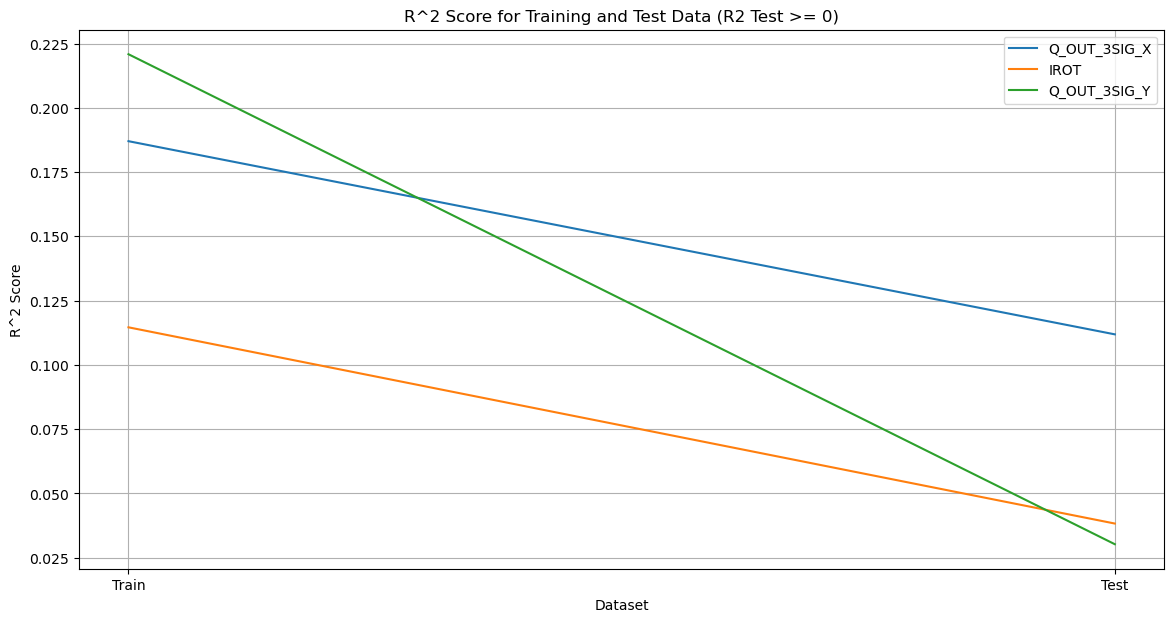

,Y Variable,R2 Train,R2 Test
0,Q_OUT_3SIG_X,0.187010,0.111882
2,IROT,0.114619,0.038299
1,Q_OUT_3SIG_Y,0.220832,0.030259


In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# R^2 점수를 저장할 데이터 프레임 생성
r2_scores_df = pd.DataFrame(columns=['Y Variable','R2 Train', 'R2 Test'])

# 각 y변수에 대해 회귀 모델을 만들고 R^2 점수를 계산
for y_var in y_vars:
    X = df[x_cmp_vars]  # 독립변수
    y = df[y_var]       # 종속변수

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # 선형 회귀 모델 훈련
    model = LinearRegression().fit(X_train, y_train)

    # R^2 점수 계산
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))

    # 결과를 데이터 프레임에 추가
    r2_scores_df.loc[len(r2_scores_df)] = [y_var, r2_train, r2_test]

# 테스트 R^2 점수가 0 이상인 경우만 선택
r2_scores_df = r2_scores_df[r2_scores_df['R2 Test'] >= 0]

# R^2 점수를 내림차순으로 정렬
r2_scores_df = r2_scores_df.sort_values(by='R2 Test', ascending=False)

# 데이터 프레임 출력
print("R^2 Scores:")
print(r2_scores_df)

# X 변수 (독립변수) 데이터 프레임 생성 및 출력
print("\nX Variables (독립변수):")
x_variables_df = pd.DataFrame(x_cmp_vars, columns=['X Variable'])
print(x_variables_df)

# 그래프 그리기
plt.figure(figsize=(14, 7))
for _, row in r2_scores_df.iterrows():
    plt.plot(['Train', 'Test'], [row['R2 Train'], row['R2 Test']], label=row['Y Variable'])
plt.xlabel('Dataset')
plt.ylabel('R^2 Score')
plt.title('R^2 Score for Training and Test Data (R2 Test >= 0)')
plt.legend()
plt.grid(True)
plt.show()


r2_scores_df 

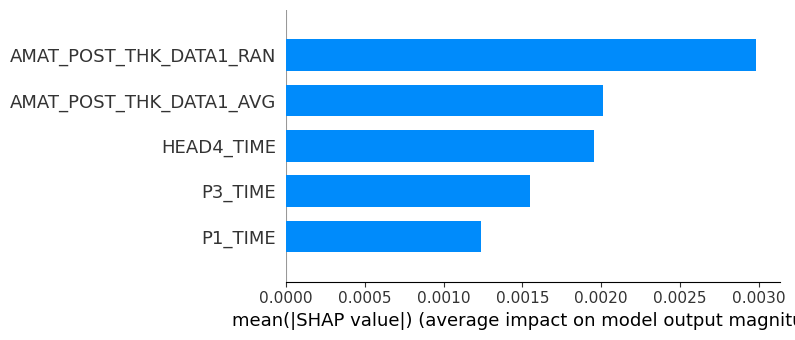

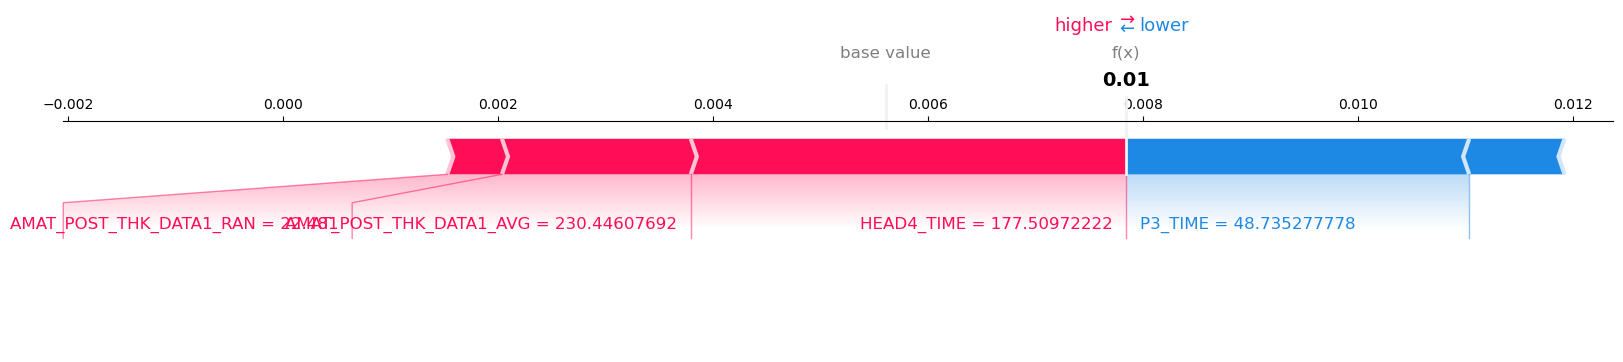

In [77]:
import shap

# 선형 회귀 모델에 대한 SHAP Explainer 초기화
explainer = shap.Explainer(model, X_train)

# SHAP 값을 계산
shap_values = explainer.shap_values(X_train)

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, X_train, plot_type="bar")

# 특정 샘플에 대한 SHAP 값 시각화 (예를 들어 첫 번째 샘플)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)


## 1-3-1. 각각의 변수로 예측 할 경우

R^2 Scores:
                X Variable    Y Variable  R2 Train   R2 Test
6               HEAD4_TIME  Q_OUT_3SIG_X  0.043834  0.088571
7               HEAD4_TIME  Q_OUT_3SIG_Y  0.054058  0.084581
3  AMAT_POST_THK_DATA1_RAN  Q_OUT_3SIG_X  0.038080  0.050465
8               HEAD4_TIME          IROT  0.010383  0.031331
4  AMAT_POST_THK_DATA1_RAN  Q_OUT_3SIG_Y  0.009309  0.020604
0  AMAT_POST_THK_DATA1_AVG  Q_OUT_3SIG_X  0.019125  0.009890


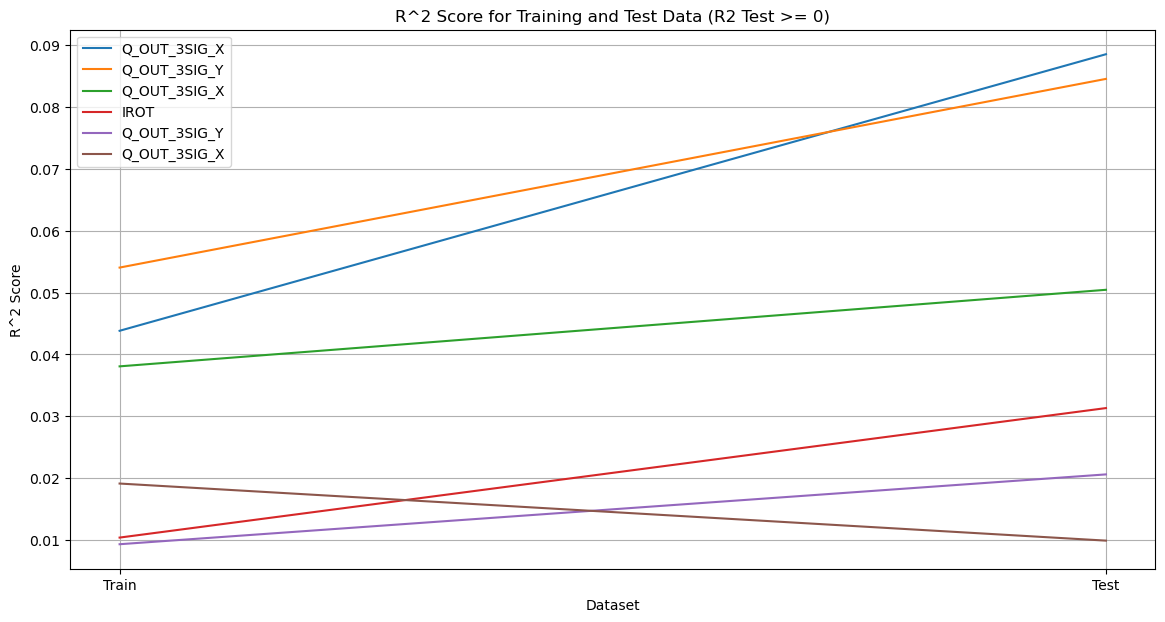

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

r2_scores_df = pd.DataFrame(columns=['X Variable', 'Y Variable', 'R2 Train', 'R2 Test'])

# 각 Y변수에 대해 각 X변수와 회귀 모델을 만들고 R^2 점수를 계산
for x_var in x_cmp_vars:  # 가정: 각 X 변수에 대해 별도의 모델을 훈련
    for y_var in y_vars:
        X = df[[x_var]]  # 이번에는 단일 X 변수를 사용
        y = df[y_var]  # 종속변수

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # 선형 회귀 모델 훈련
        model = LinearRegression().fit(X_train, y_train)

        # R^2 점수 계산
        r2_train = r2_score(y_train, model.predict(X_train))
        r2_test = r2_score(y_test, model.predict(X_test))

        # 결과를 데이터 프레임에 추가
        new_row = pd.DataFrame({'X Variable': [x_var], 'Y Variable': [y_var], 'R2 Train': [r2_train], 'R2 Test': [r2_test]})
        r2_scores_df = pd.concat([r2_scores_df, new_row], ignore_index=True)

# 테스트 R^2 점수가 0 이상인 경우만 선택
r2_scores_df = r2_scores_df[r2_scores_df['R2 Test'] >= 0]


# R^2 점수를 내림차순으로 정렬
r2_scores_df = r2_scores_df.sort_values(by='R2 Test', ascending=False)

# 데이터 프레임 출력
print("R^2 Scores:")
print(r2_scores_df)

# 그래프 그리기
plt.figure(figsize=(14, 7))
for _, row in r2_scores_df.iterrows():
    plt.plot(['Train', 'Test'], [row['R2 Train'], row['R2 Test']], label=row['Y Variable'])
plt.xlabel('Dataset')
plt.ylabel('R^2 Score')
plt.title('R^2 Score for Training and Test Data (R2 Test >= 0)')
plt.legend()
plt.grid(True)
plt.show()




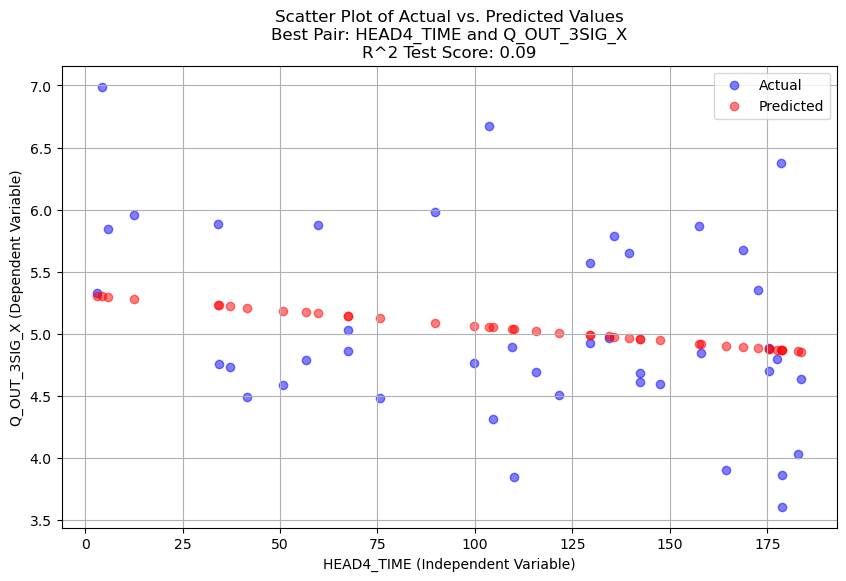

In [79]:
# R^2 테스트 점수가 가장 높은 행을 선택
best_row = r2_scores_df.iloc[0]

# 해당 행의 X, Y 변수 선택
best_x_var = best_row['X Variable']
best_y_var = best_row['Y Variable']

# 선택된 X, Y 변수에 대한 데이터 준비
X_best = df[[best_x_var]]
y_best = df[best_y_var]

# 데이터 분할
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size=0.25, random_state=42)

# 최적의 변수에 대해 다시 모델 훈련 (선택된 최고의 X, Y 쌍을 사용)
model_best = LinearRegression().fit(X_train_best, y_train_best)

# 테스트 데이터에 대한 예측
y_pred_best = model_best.predict(X_test_best)

# 실제 값과 예측 값 사이의 scatter plot 생성
plt.figure(figsize=(10, 6))
plt.scatter(X_test_best, y_test_best, color='blue', alpha=0.5, label='Actual')
plt.scatter(X_test_best, y_pred_best, color='red', alpha=0.5, label='Predicted')
plt.title(f'Scatter Plot of Actual vs. Predicted Values\nBest Pair: {best_x_var} and {best_y_var}\nR^2 Test Score: {best_row["R2 Test"]:.2f}')
plt.xlabel(f'{best_x_var} (Independent Variable)')
plt.ylabel(f'{best_y_var} (Dependent Variable)')
plt.legend()
plt.grid(True)
plt.show()


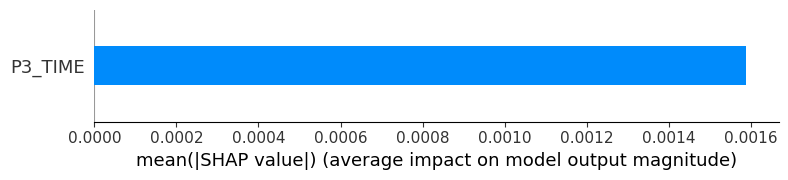

divide by zero encountered in scalar divide


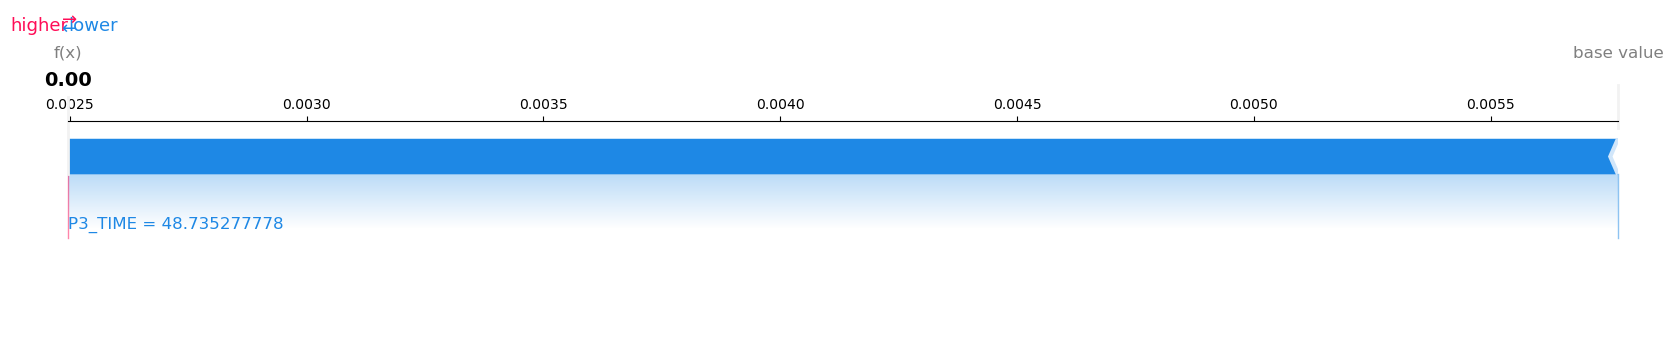

In [80]:
import shap

# 선형 회귀 모델에 대한 SHAP Explainer 초기화
explainer = shap.Explainer(model, X_train)

# SHAP 값을 계산
shap_values = explainer.shap_values(X_train)

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, X_train, plot_type="bar")

# 특정 샘플에 대한 SHAP 값 시각화 (예를 들어 첫 번째 샘플)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)


## 1-4. 각 주요 변수별 R^2 확인 (y_vars 변경 및 x_cmp_vars 제외)

Top 5 Model Results (R2 Test >= 0):
   X Variable Group    Y Variable  R2 Train   R2 Test
29       x_slp_vars          IROT  0.187528  0.167553
28       x_slp_vars  Q_OUT_3SIG_Y  0.187528  0.167553
27       x_slp_vars  Q_OUT_3SIG_X  0.187528  0.167553
12         x_t_vars  Q_OUT_3SIG_X  0.092692  0.162045
13         x_t_vars  Q_OUT_3SIG_Y  0.092692  0.162045
14         x_t_vars          IROT  0.092692  0.162045
9          x_r_vars  Q_OUT_3SIG_X  0.108485  0.089601
10         x_r_vars  Q_OUT_3SIG_Y  0.108485  0.089601
11         x_r_vars          IROT  0.108485  0.089601
6          x_l_vars  Q_OUT_3SIG_X  0.056499  0.064317


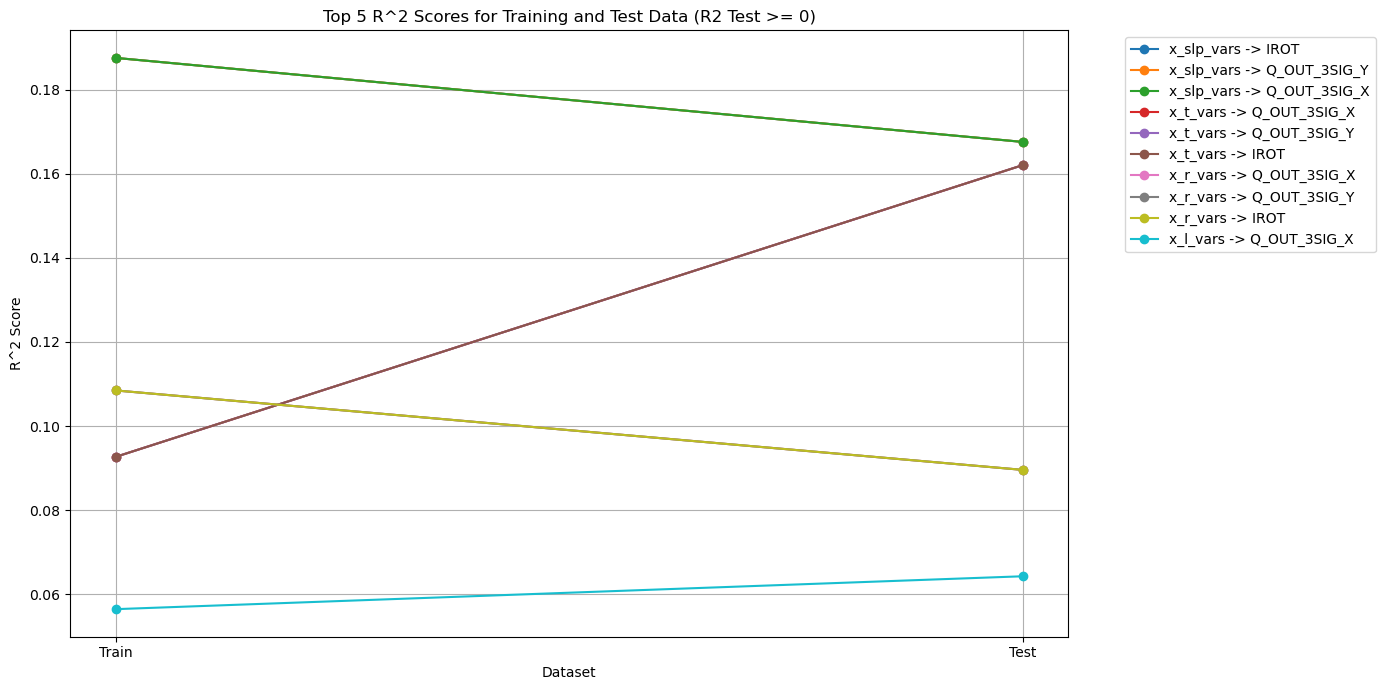

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 모델 결과를 저장할 데이터 프레임 초기화
model_results = []

# 각 x변수 그룹별로 y변수 예측 모델 생성 및 평가
for x_var_group, x_vars in x_variables.items():
    for y_var in y_vars:
        # 독립변수와 종속변수 선택
        X = df[x_vars]
        y = df[y_vars]

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # 모델 훈련
        model = LinearRegression().fit(X_train, y_train)

        # R^2 점수 계산
        r2_train = r2_score(y_train, model.predict(X_train))
        r2_test = r2_score(y_test, model.predict(X_test))

        # 결과 저장
        model_results.append({
            'X Variable Group': x_var_group,
            'Y Variable': y_var,
            'R2 Train': r2_train,
            'R2 Test': r2_test
        })

# 결과 데이터 프레임 생성 및 정렬
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values(by='R2 Test', ascending=False)

# R^2 점수가 0 이상인 결과 중 상위 10개만 선택
top_5_results_df = results_df[results_df['R2 Test'] >= 0].head(10)

# 결과 출력
print("Top 5 Model Results (R2 Test >= 0):")
print(top_5_results_df)

# 그래프 그리기
plt.figure(figsize=(14, 7))
for _, row in top_5_results_df.iterrows():
    if row['R2 Test'] >= 0:  # R^2 점수가 0 이상인 경우만 시각화
        plt.plot(['Train', 'Test'], [row['R2 Train'], row['R2 Test']], '-o', label=f"{row['X Variable Group']} -> {row['Y Variable']}")
plt.xlabel('Dataset')
plt.ylabel('R^2 Score')
plt.title('Top 5 R^2 Scores for Training and Test Data (R2 Test >= 0)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



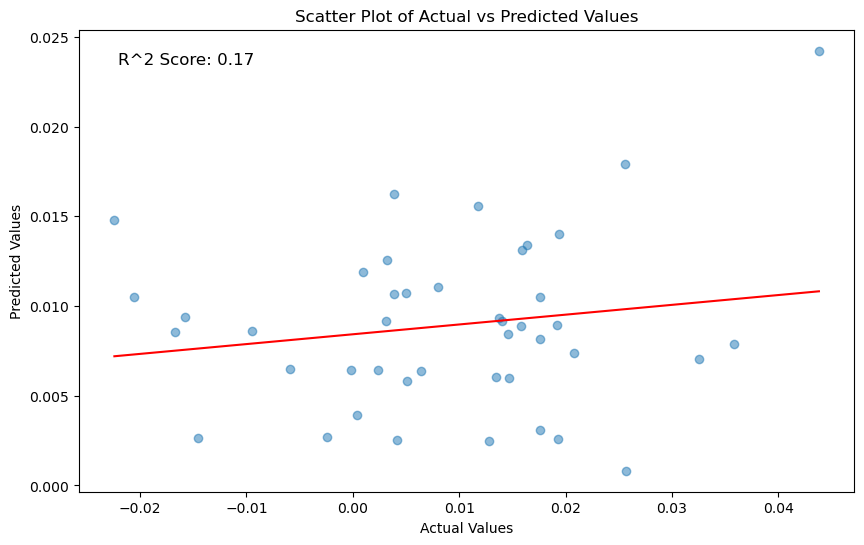

In [82]:
# top_5_results_df에서 R^2 테스트 점수가 가장 높은 행 선택
top_result = top_5_results_df.iloc[0]

# 해당하는 X Variable Group과 Y Variable 선택
top_x_var_group = top_result['X Variable Group']
top_y_var = top_result['Y Variable']

# 데이터 프레임 df에서 선택된 Y 변수에 대한 데이터 준비
X_top_group = df[x_variables[top_x_var_group]]
y_top = df[top_y_var]

#데이터 분할
X_train_top_group, X_test_top_group, y_train_top, y_test_top = train_test_split(X_top_group, y_top, test_size=0.25, random_state=42)

model_top_group = LinearRegression().fit(X_train_top_group, y_train_top)
y_pred_top_group = model_top_group.predict(X_test_top_group)

slope, intercept = np.polyfit(y_test_top, y_pred_top_group, 1)

line_x = np.array([y_test_top.min(),y_test_top.max()])
line_y = slope*line_x + intercept

plt.figure(figsize=(10,6))
plt.scatter(y_test_top, y_pred_top_group, alpha=0.5)
plt.plot(line_x, line_y, 'r', label='Fit Line')
r2_score_text = f'R^2 Score: {top_result["R2 Test"]:.2f}'
plt.text(0.05, 0.95, r2_score_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.title(f'Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


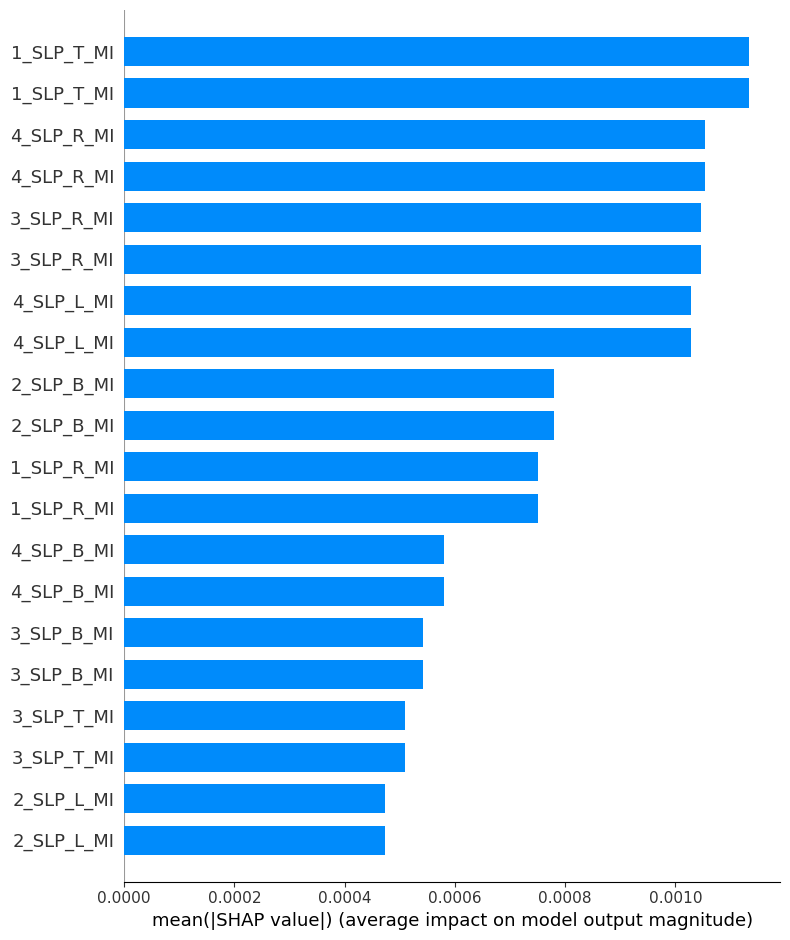

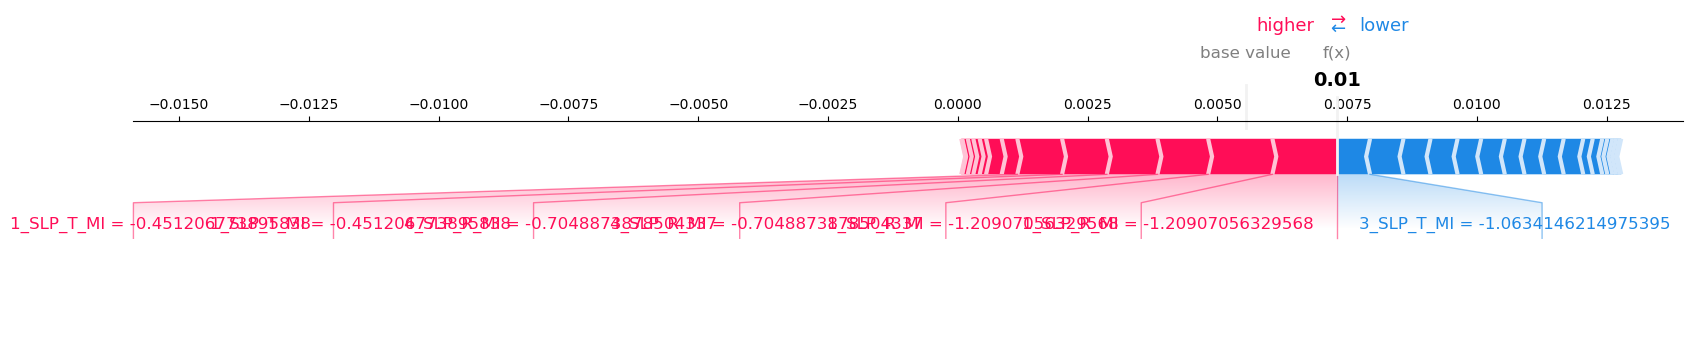

In [83]:
# !pip install shap

import shap

# 상위 5개 결과 중 가장 성능이 좋은 모델 선택 (여기서는 간단히 첫 번째 모델을 선택)
best_model_info = top_5_results_df.iloc[0]
best_x_vars = x_variables[best_model_info['X Variable Group']]
best_y_var = best_model_info['Y Variable']

# 독립변수와 종속변수 선택
X_best = df[best_x_vars]
y_best = df[best_y_var]

# 데이터 분할
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size=0.25, random_state=42)

# 가장 성능이 좋은 모델 훈련
model_best = LinearRegression().fit(X_train_best, y_train_best)

# SHAP Explainer 초기화
explainer = shap.Explainer(model_best, X_train_best)

# SHAP 값을 계산
shap_values = explainer.shap_values(X_train_best)

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, X_train_best, plot_type="bar")

# 첫 번째 샘플에 대한 SHAP 값 시각화
# 이 코드는 matplotlib 기반의 시각화가 활성화되어 있어야 합니다.
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_best.iloc[0,:], matplotlib=True)


## 1-4-1. 상위 x변수만 이용하여 예측 모델 생성 (중복된 변수는 제거)

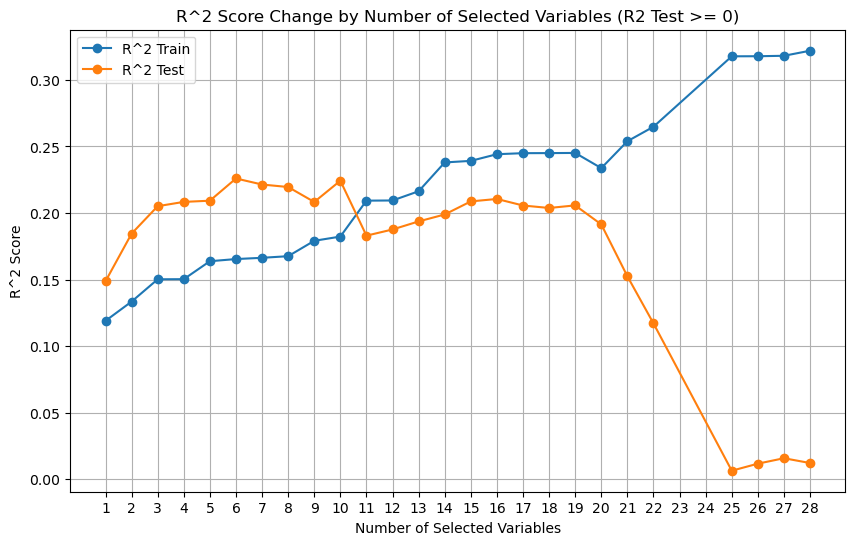

Best model uses 1 variables: ['2_SLOPE_R']


In [84]:
# 예시: 상위 X개 변수 그룹을 선택
top_n = 10  # 사용자가 정의한 상위 변수 그룹의 수

# results_df에서 상위 X개의 변수 그룹을 선택합니다 (가정: results_df가 이미 존재하며 필요한 정보를 포함)
top_variable_groups = results_df.nlargest(top_n, 'R2 Test')['X Variable Group'].unique()

# 선택된 변수 그룹에서 중복 없이 모든 X변수를 추출
selected_variables = set()
for group in top_variable_groups:
    selected_variables.update(x_variables[group])  # x_variables: 변수 그룹과 변수 목록을 매핑

y_vars = ['Q_OUT_3SIG_X', 'Q_OUT_3SIG_Y', 'IROT']
# 변수 그룹의 개수에 따른 R^2 점수 변화를 저장할 리스트
r2_scores_summary = []

# 중복 제거된 X변수들을 사용하여 모델 구성 및 평가
for num_vars in range(1, len(selected_variables) + 1):
    current_vars = list(selected_variables)[:num_vars]
    X = df[current_vars]
    y = df[y_vars[0]]  # 첫 번째 y_var 사용

    # 데이터 분할 및 모델 학습
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)

    # R^2 점수 저장 (0 이상인 경우만)
    if r2_test >= 0:
        r2_scores_summary.append({
            'Number of Variables': num_vars,
            'R2 Train': r2_train,
            'R2 Test': r2_test
        })

# 데이터 프레임 생성 및 정렬
r2_scores_df = pd.DataFrame(r2_scores_summary)
r2_scores_df_sorted = r2_scores_df.sort_values(by='Number of Variables')

# 꺾은선 그래프로 변화 표시
plt.figure(figsize=(10, 6))
plt.plot(r2_scores_df_sorted['Number of Variables'], r2_scores_df_sorted['R2 Train'], marker='o', label='R^2 Train')
plt.plot(r2_scores_df_sorted['Number of Variables'], r2_scores_df_sorted['R2 Test'], marker='o', label='R^2 Test')
plt.xlabel('Number of Selected Variables')
plt.ylabel('R^2 Score')
plt.title('R^2 Score Change by Number of Selected Variables (R2 Test >= 0)')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(selected_variables) + 1))  # X축에 표시될 틱을 변수의 개수로 설정
plt.show()

# 가장 높은 Test R^2 score를 가진 모델에 사용된 변수 출력
best_num_vars = int(r2_scores_df.iloc[0]['Number of Variables'])  # 정수형으로 변환
best_variables = list(selected_variables)[:best_num_vars]
print(f"Best model uses {best_num_vars} variables: {best_variables}")


# 해당 변수로 모델 훈련 (best)
X_best = df[best_variables]
y_best = df[y_vars[0]]  # 첫 번째 y_var 사용
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size=0.25, random_state=42)
model_best = LinearRegression().fit(X_train_best, y_train_best)


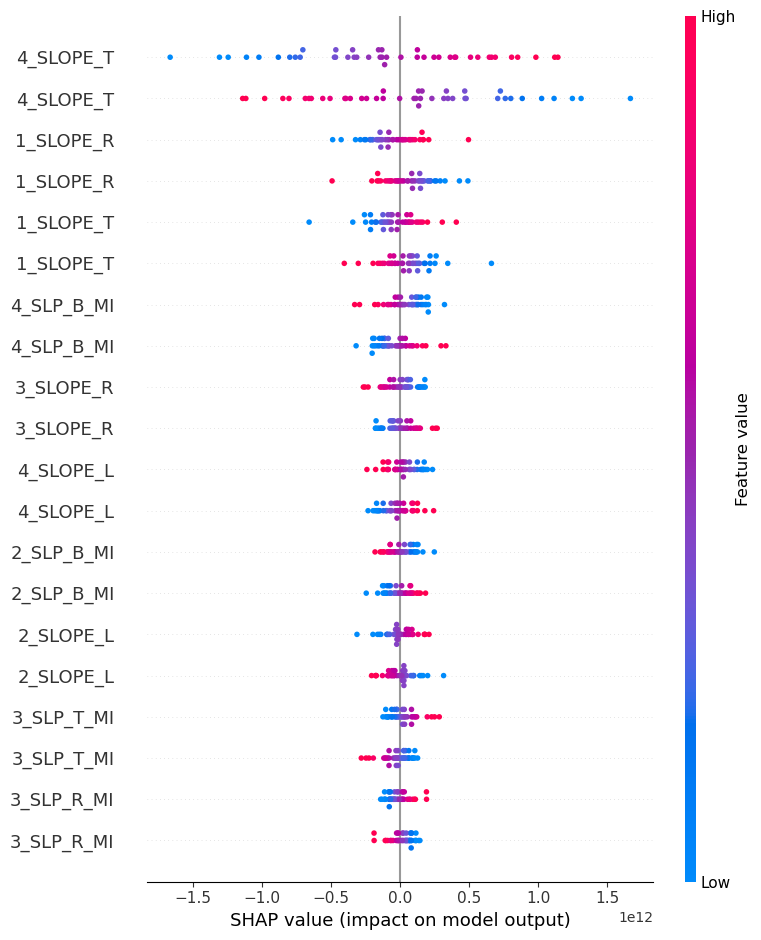

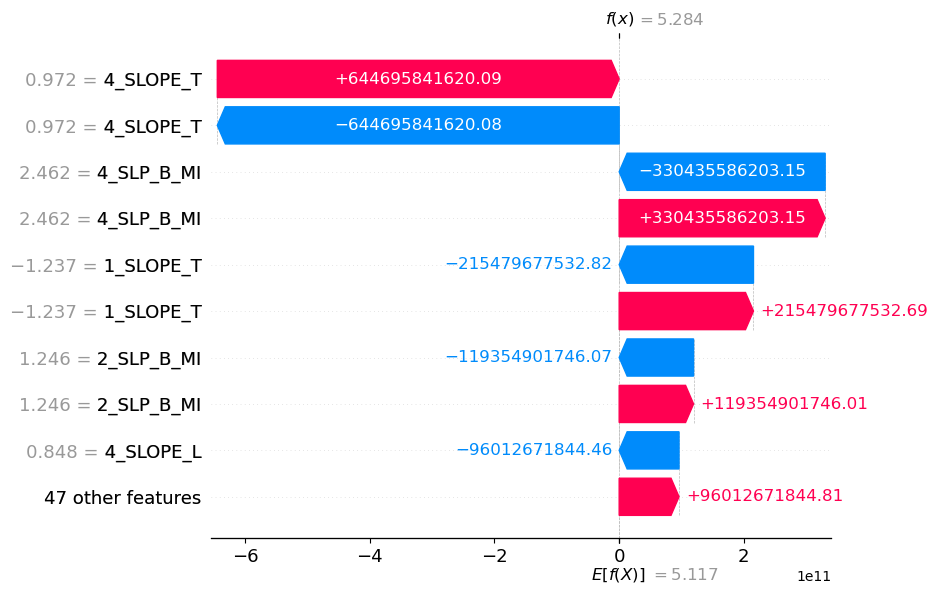

In [85]:
# SHAP Explainer 생성
explainer = shap.Explainer(model, X_train)

# SHAP 값 계산
shap_values = explainer(X_test)

# SHAP 요약 플롯 그리기
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)

# 특정 샘플에 대한 SHAP 값 그리기 (예: 첫 번째 샘플)
shap.plots.waterfall(shap_values[0])
shap.force_plot(shap_values.base_values, shap_values.values[0], X_train.iloc[0])


## 1-4-2 유효한 변수로만 모델 생성 (전진선택, 후진선택법은 파이썬 라이브러리가 없음) R^2 score 기준으로 선택함

    Number of Variables  R2 Train   R2 Test
0                     1  0.119029  0.148758
1                     2  0.133491  0.184531
2                     3  0.150241  0.205159
3                     4  0.150328  0.208376
4                     5  0.163817  0.209276
5                     6  0.165439  0.225963
6                     7  0.168368  0.241722
7                     8  0.170373  0.256165
8                     9  0.178794  0.263186
9                    10  0.189525  0.271342
10                   11  0.189580  0.273344
11                   12  0.190332  0.275313
12                   13  0.190582  0.278554
13                   14  0.219657  0.327334
14                   15  0.228338  0.351461
15                   16  0.230029  0.356216


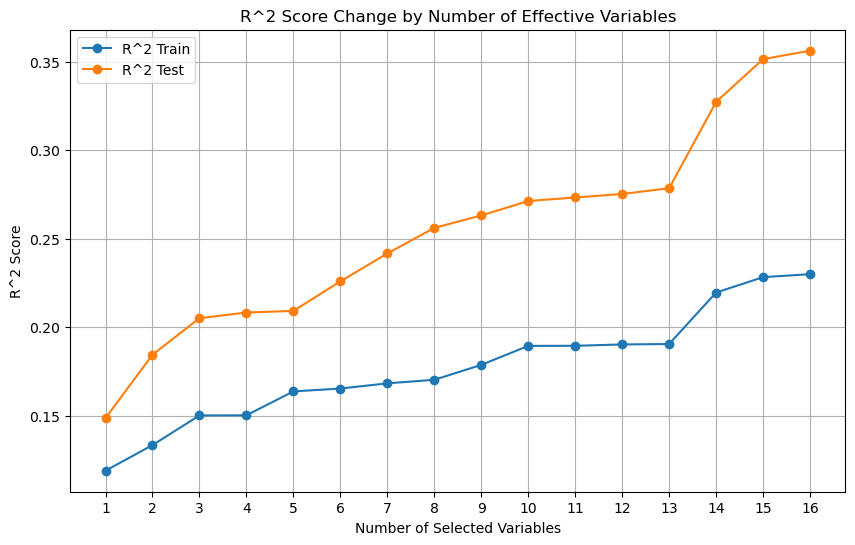

Best model uses 16 variables: ['2_SLOPE_R', '4_SLOPE_T', '1_SLP_L_MI', '1_SLP_B_MI', '1_SLOPE_R', '4_SLP_L_MI', '3_SLOPE_T', '4_SLP_B_MI', '3_SLP_R_MI', '4_SLP_R_MI', '3_SLOPE_R', '3_SLOPE_L', '2_SLP_L_MI', '4_SLP_T_MI', '1_SLOPE_T', '2_SLP_R_MI']


In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 상위 X개 변수 그룹을 선택
top_n = 10  # 사용자가 정의한 상위 변수 그룹의 수

# results_df에서 상위 X개의 변수 그룹을 선택합니다 (가정: results_df가 이미 존재하며 필요한 정보를 포함)
top_variable_groups = results_df.nlargest(top_n, 'R2 Test')['X Variable Group'].unique()

# 선택된 변수 그룹에서 중복 없이 모든 X변수를 추출
selected_variables = set()
for group in top_variable_groups:
    selected_variables.update(x_variables[group])  # x_variables: 변수 그룹과 변수 목록을 매핑

# 변수 그룹의 개수에 따른 R^2 점수 변화를 저장할 리스트
r2_scores_summary = []

# 성능 개선을 위해 유효한 변수만 추가하는 접근법
best_r2_test = -np.inf  # 최고의 테스트 R^2 점수 초기화
best_variables = []  # 최고의 변수 목록 초기화

for var in selected_variables:
    current_vars = best_variables + [var]  # 현재 변수 목록에 새 변수 추가
    X = df[current_vars]
    y = df[y_vars[0]]  # 첫 번째 y_var 사용

    # 데이터 분할 및 모델 학습
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    r2_test = model.score(X_test, y_test)

    # 성능이 개선되었는지 확인
    if r2_test > best_r2_test:
        best_r2_test = r2_test  # 최고 테스트 R^2 점수 업데이트
        best_variables.append(var)  # 변수 목록에 추가

        # R^2 점수 저장
        r2_scores_summary.append({
            'Number of Variables': len(best_variables),
            'R2 Train': model.score(X_train, y_train),
            'R2 Test': r2_test
        })

# 데이터 프레임 생성 및 출력
r2_scores_df = pd.DataFrame(r2_scores_summary)
print(r2_scores_df)
# 꺾은선 그래프로 변화 표시
plt.figure(figsize=(10, 6))
plt.plot(r2_scores_df['Number of Variables'], r2_scores_df['R2 Train'], marker='o', label='R^2 Train')
plt.plot(r2_scores_df['Number of Variables'], r2_scores_df['R2 Test'], marker='o', label='R^2 Test')
plt.xlabel('Number of Selected Variables')
plt.ylabel('R^2 Score')
plt.title('R^2 Score Change by Number of Effective Variables')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(best_variables) + 1))
plt.show()

# 가장 높은 Test R^2 score를 가진 모델에 사용된 변수 출력
print(f"Best model uses {len(best_variables)} variables: {best_variables}")


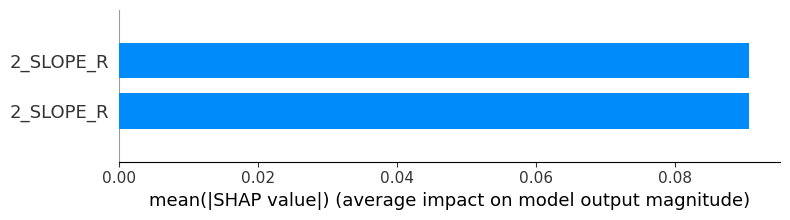

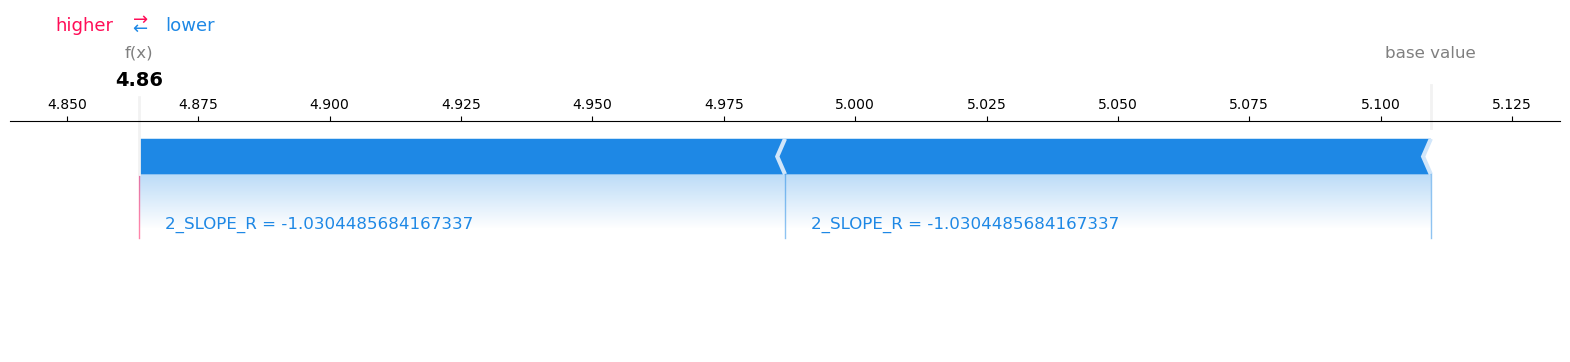

In [87]:
# !pip install shap

import shap

# SHAP Explainer 객체를 생성합니다.
# Linear 모델의 경우, model.predict 대신 model 객체를 직접 넘겨주는 것이 일반적입니다.
explainer = shap.Explainer(model_best, X_train_best)

# SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X_train_best)

# SHAP 요약 플롯을 시각화합니다.
# 이 플롯은 각 변수가 모델의 예측에 미치는 영향을 나타냅니다.
shap.summary_plot(shap_values, X_train_best, plot_type="bar")

# SHAP 값으로 특정 샘플(예: 첫 번째 샘플)에 대한 예측의 기여도를 시각화할 수도 있습니다.
# force_plot은 개별 예측에 대한 SHAP 값의 기여도를 시각적으로 표현합니다.
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_best.iloc[0,:], matplotlib=True)


## 1-4-3. CMP Source Data 변수 추가 하여 예측력 확인

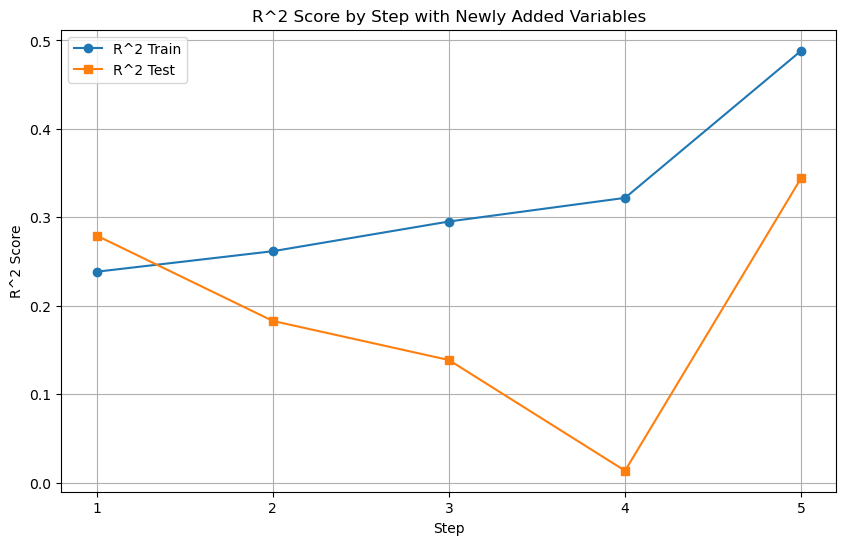

Step 1: Newly Added Variables: 1_SLP_L_MI, 1_SLP_B_MI, 4_SLP_L_MI, 3_SLP_T_MI, 2_SLP_L_MI, 4_SLP_B_MI, 3_SLP_R_MI, 4_SLP_R_MI, 3_SLP_B_MI, 2_SLP_T_MI, 4_SLP_T_MI, 1_SLP_T_MI, 2_SLP_R_MI, 1_SLP_R_MI, 2_SLP_B_MI, 3_SLP_L_MI
Step 2: Newly Added Variables: 2_SLOPE_T, 1_SLOPE_T, 3_SLOPE_T, 4_SLOPE_T
Step 3: Newly Added Variables: 4_SLOPE_R, 2_SLOPE_R, 3_SLOPE_R, 1_SLOPE_R
Step 4: Newly Added Variables: 2_SLOPE_L, 4_SLOPE_L, 1_SLOPE_L, 3_SLOPE_L
Step 5: Newly Added Variables: HEAD4_TIME, P3_TIME, P1_TIME, AMAT_POST_THK_DATA1_AVG, AMAT_POST_THK_DATA1_RAN


In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 가정: results_df, df, y_vars, x_cmp_vars가 이미 정의되어 있고, 필요한 데이터를 포함하고 있음

# 상위 x변수 그룹 이름을 가져옴
top_x_groups = results_df.nlargest(10, 'R2 Test')['X Variable Group'].tolist()

# cmp_vars를 top_x_groups에 추가
top_x_groups.append('x_cmp_vars')

# 변수 그룹별로 각 단계에서 추가된 변수 추적 및 R^2 점수 계산 로직을 정밀화
added_vars = set()
steps = []
r2_scores_train = []
r2_scores_test = []
step_counter = 1  # 명시적인 단계 카운터 사용

for group_name in top_x_groups:
    current_vars = set(x_variables[group_name]) if group_name in x_variables else set(globals()[group_name])
    new_vars = current_vars - added_vars

    if new_vars:
        added_vars.update(new_vars)
        steps.append(f"Step {step_counter}: Newly Added Variables: {', '.join(new_vars)}")

        X = df[list(added_vars)]
        y = df[y_vars[0]]

        # 데이터 분할 및 모델 훈련
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        model = LinearRegression().fit(X_train, y_train)

        # R^2 점수 계산
        r2_train = r2_score(y_train, model.predict(X_train))
        r2_test = r2_score(y_test, model.predict(X_test))

        # R^2 점수 저장
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

        step_counter += 1  # 단계 카운터 증가

# R^2 점수 데이터 프레임 생성 및 출력
r2_scores_df = pd.DataFrame({
    'Step': range(1, step_counter),
    'R2_Train': r2_scores_train,
    'R2_Test': r2_scores_test
})

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(r2_scores_df['Step'], r2_scores_df['R2_Train'], label='R^2 Train', marker='o')
plt.plot(r2_scores_df['Step'], r2_scores_df['R2_Test'], label='R^2 Test', marker='s')
plt.xlabel('Step')
plt.ylabel('R^2 Score')
plt.title('R^2 Score by Step with Newly Added Variables')
plt.xticks(r2_scores_df['Step'])
plt.legend()
plt.grid(True)
plt.show()

# 추가된 변수 출력
for step in steps:
    print(step)


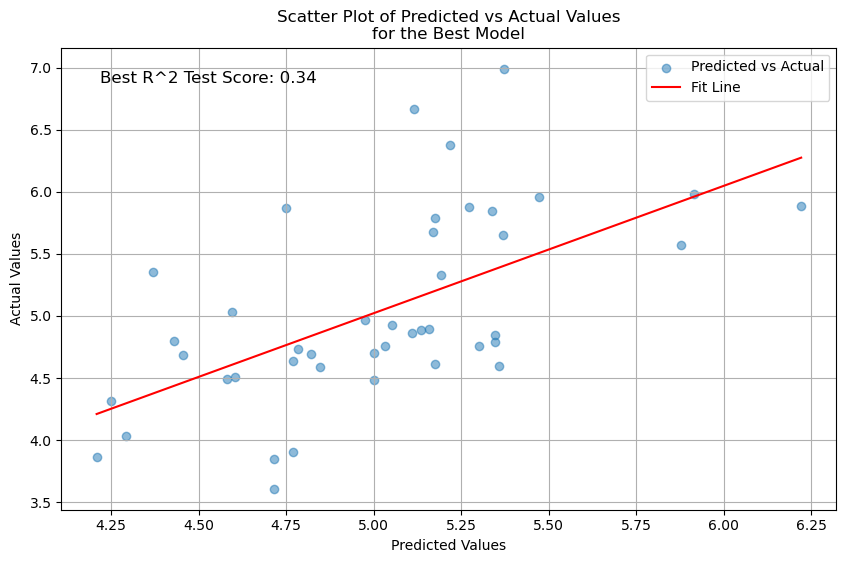

Best R^2 Test Score: 0.344


In [89]:
# 최종 모델을 사용하여 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# 예측 값과 실제 값 사이의 scatter plot 생성, 예측 값을 x축, 실제 값을 y축으로 설정
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, alpha=0.5, label='Predicted vs Actual')
plt.title('Scatter Plot of Predicted vs Actual Values\nfor the Best Model')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# 최고의 R^2 테스트 점수와 관련된 정보 출력
best_r2_test = np.max(r2_scores_test)  # 최고의 R^2 테스트 점수 계산
plt.text(0.05, 0.95, f'Best R^2 Test Score: {best_r2_test:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# 최적의 선형 관계 선(fit line) 추가
slope, intercept = np.polyfit(y_pred, y_test, 1)
line_x = np.array([y_pred.min(), y_pred.max()])
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'r-', label='Fit Line')  # 최적의 선형 관계 선 추가
plt.legend()
plt.grid(True)
plt.show()


print(f"Best R^2 Test Score: {best_r2_test:.3f}")


## 1-4-4. CMP PARA 추가해서 유의한 변수만으로 모델 실행

    Step  R2_Train   R2_Test
0      1  0.099065  0.093693
1      2  0.094403  0.124043
2      3  0.154272  0.131395
3      4  0.154367  0.132922
4      5  0.154489  0.136646
5      6  0.177100  0.170339
6      7  0.192826  0.212263
7      8  0.198818  0.213479
8      9  0.212093  0.254103
9     10  0.213660  0.279970
10    11  0.214009  0.282337
11    12  0.226646  0.319449
12    13  0.230108  0.333534
13    14  0.230484  0.334172
14    15  0.231378  0.334265
15    16  0.231384  0.334590
16    17  0.318628  0.402169
17    18  0.318159  0.406794
18    19  0.345238  0.418377


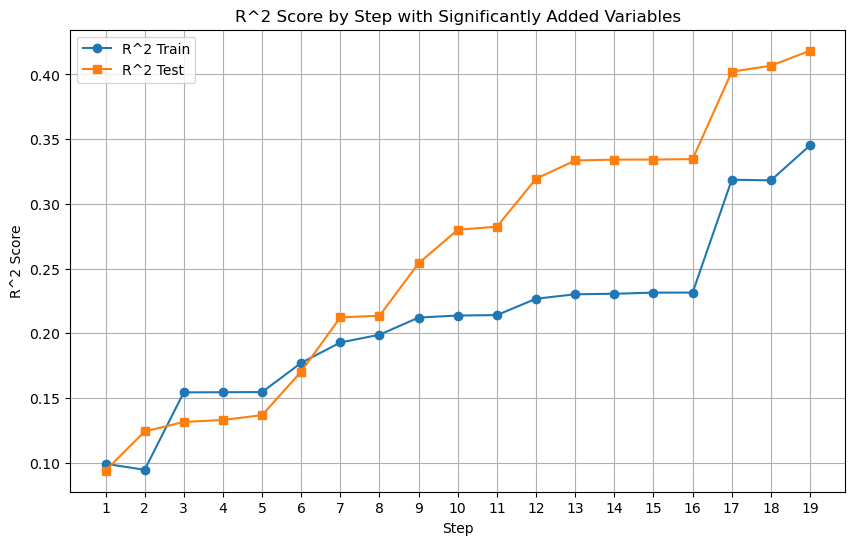

Step 1: Newly Added Variable: 1_SLP_L_MI
Step 2: Newly Added Variable: 1_SLP_B_MI
Step 3: Newly Added Variable: 3_SLP_T_MI
Step 4: Newly Added Variable: 2_SLP_L_MI
Step 5: Newly Added Variable: 4_SLP_B_MI
Step 6: Newly Added Variable: 3_SLP_R_MI
Step 7: Newly Added Variable: 4_SLP_R_MI
Step 8: Newly Added Variable: 2_SLP_T_MI
Step 9: Newly Added Variable: 4_SLP_T_MI
Step 10: Newly Added Variable: 1_SLP_T_MI
Step 11: Newly Added Variable: 3_SLP_L_MI
Step 12: Newly Added Variable: 4_SLP_L_MI
Step 13: Newly Added Variable: 3_SLOPE_R
Step 14: Newly Added Variable: 1_SLOPE_R
Step 15: Newly Added Variable: 2_SLOPE_L
Step 16: Newly Added Variable: 3_SLOPE_L
Step 17: Newly Added Variable: HEAD4_TIME
Step 18: Newly Added Variable: P3_TIME
Step 19: Newly Added Variable: AMAT_POST_THK_DATA1_AVG


In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 가정: results_df, df, y_vars, x_cmp_vars가 이미 정의되어 있고, 필요한 데이터를 포함하고 있음

# 상위 x변수 그룹 이름을 가져옴
top_x_groups = results_df.nlargest(10, 'R2 Test')['X Variable Group'].tolist()

# cmp_vars를 top_x_groups에 추가
top_x_groups.append('x_cmp_vars')

# 변수 그룹별로 각 단계에서 추가된 변수 추적 및 R^2 점수 계산 로직을 정밀화
added_vars = set()
steps = []
r2_scores_train = []
r2_scores_test = []
step_counter = 1  # 명시적인 단계 카운터 사용
best_r2_test = -np.inf  # 최고의 테스트 R^2 점수 초기화

for group_name in top_x_groups:
    current_vars = set(x_variables[group_name]) if group_name in x_variables else set(globals()[group_name])
    new_vars = current_vars - added_vars
    temp_added_vars = added_vars.copy()  # 임시로 추가된 변수들을 저장

    for var in new_vars:
        temp_added_vars.add(var)
        X = df[list(temp_added_vars)]
        y = df[y_vars[0]]

        # 데이터 분할 및 모델 훈련
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        model = LinearRegression().fit(X_train, y_train)

        # R^2 점수 계산
        r2_train = r2_score(y_train, model.predict(X_train))
        r2_test = r2_score(y_test, model.predict(X_test))

        # 성능이 개선되었는지 확인
        if r2_test > best_r2_test:
            best_r2_test = r2_test
            added_vars = temp_added_vars.copy()  # 성능이 개선된 변수 추가
            r2_scores_train.append(r2_train)
            r2_scores_test.append(r2_test)
            steps.append(f"Step {step_counter}: Newly Added Variable: {var}")
            step_counter += 1
        else:
            temp_added_vars.remove(var)  # 성능이 개선되지 않는 변수 제외

# R^2 점수 데이터 프레임 생성 및 출력
r2_scores_df = pd.DataFrame({
    'Step': range(1, step_counter),
    'R2_Train': r2_scores_train,
    'R2_Test': r2_scores_test
})

# R^2 점수 데이터 프레임 출력
print(r2_scores_df)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(r2_scores_df['Step'], r2_scores_df['R2_Train'], label='R^2 Train', marker='o')
plt.plot(r2_scores_df['Step'], r2_scores_df['R2_Test'], label='R^2 Test', marker='s')
plt.xlabel('Step')
plt.ylabel('R^2 Score')
plt.title('R^2 Score by Step with Significantly Added Variables')
plt.xticks(range(1, len(r2_scores_train) + 1))
plt.legend()
plt.grid(True)
plt.show()

# 추가된 변수 출력
for step in steps:
    print(step)




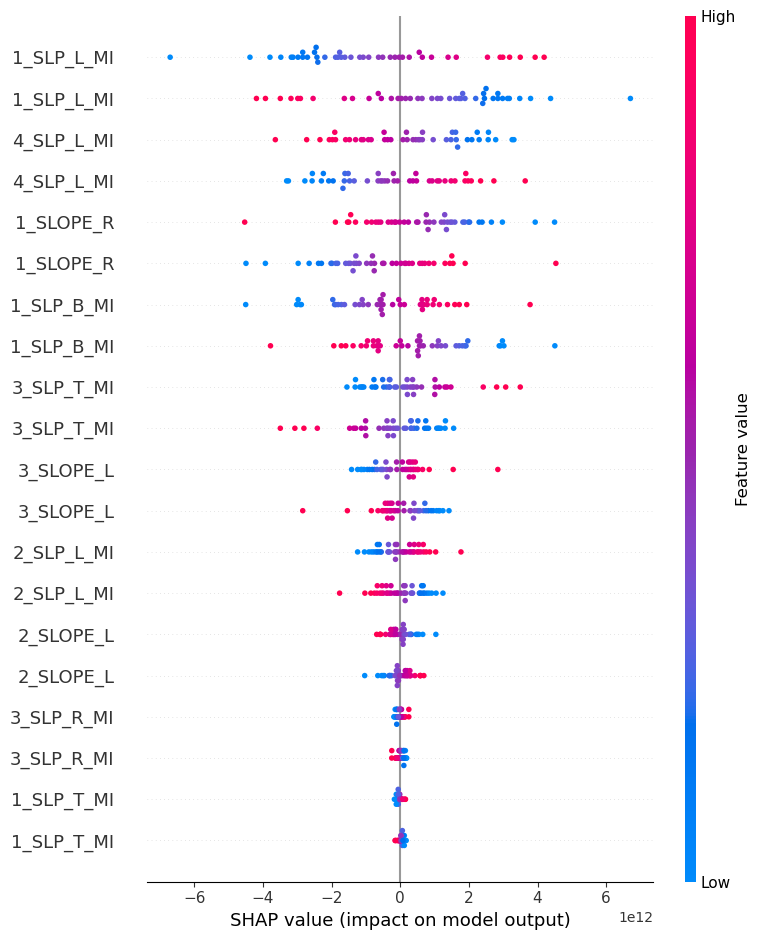

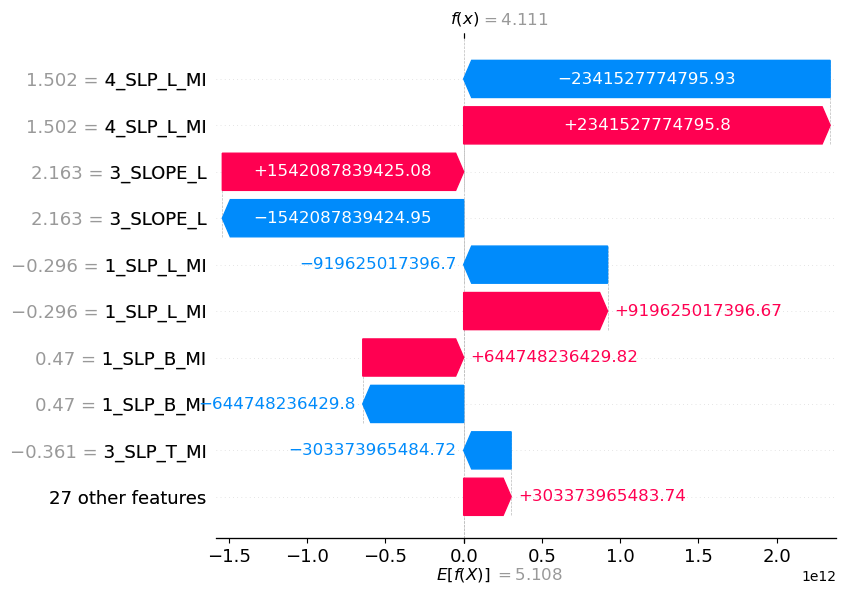

In [91]:
# SHAP Explainer 생성
explainer = shap.Explainer(model, X_train)

# SHAP 값 계산
shap_values = explainer(X_test)

# SHAP 요약 플롯 그리기
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)

# 특정 샘플에 대한 SHAP 값 그리기 (예: 첫 번째 샘플)
shap.plots.waterfall(shap_values[0])
# 특정 샘플에 대한 SHAP 값 시각화 (예를 들어 첫 번째 샘플)
shap.force_plot(shap_values.base_values, shap_values.values[0], X_train.iloc[0])

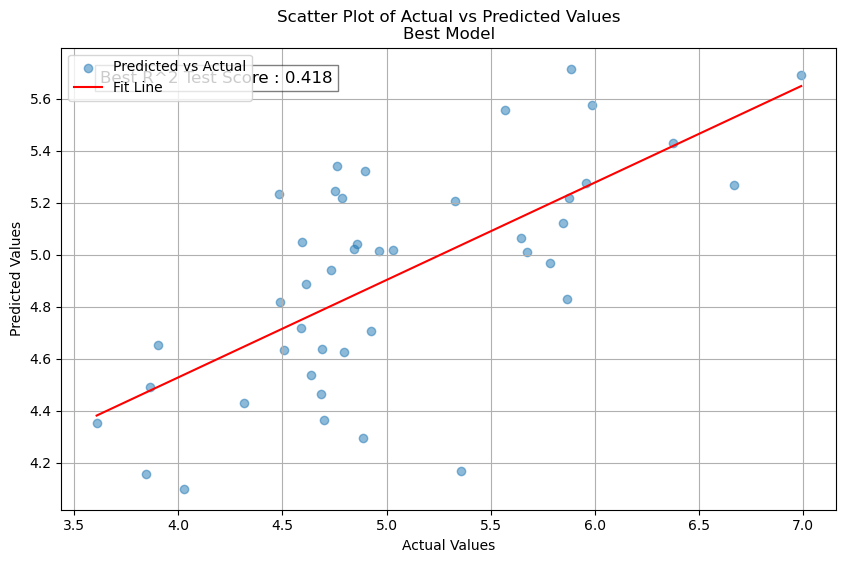

Best R^2 Test Score: 0.418


In [92]:
# 최고의 R^2 테스트 점수에 해당하는 변수 사용
X_best = df[list(added_vars)]  # 최고의 변수 세트
y_best = df[y_vars[0]]  # y_vars 리스트에서 첫 번째 변수 사용

# 데이터 분할
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size=0.25, random_state=42)

# 최적의 모델 훈련
model_best = LinearRegression().fit(X_train_best, y_train_best)

# 테스트 데이터에 대한 예측 수행
y_pred_best = model_best.predict(X_test_best)


# 실제 값과 예측 값 사이의 scatter plot 생성
plt.figure(figsize=(10, 6))
plt.scatter(y_test_best, y_pred_best, alpha=0.5, label='Predicted vs Actual')
plt.title('Scatter Plot of Actual vs Predicted Values\nBest Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# 최적의 선형 관계 선 추가 (fit line)
slope, intercept = np.polyfit(y_test_best, y_pred_best, 1)
line_x = np.array([y_test_best.min(), y_test_best.max()])
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'r', label='Fit Line')

# R2 score Text 추가 
r2_text = f"Best R^2 Test Score : {best_r2_test:.3f}"
plt.text(0.05, 0.95, r2_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.show()

# 최고의 R^2 테스트 점수 출력
print(f"Best R^2 Test Score: {best_r2_test:.3f}")


## 1-4-5 cmp Para 변수 추가 전, 후 모델 성능 비교 (이전 model에 변수 추가)

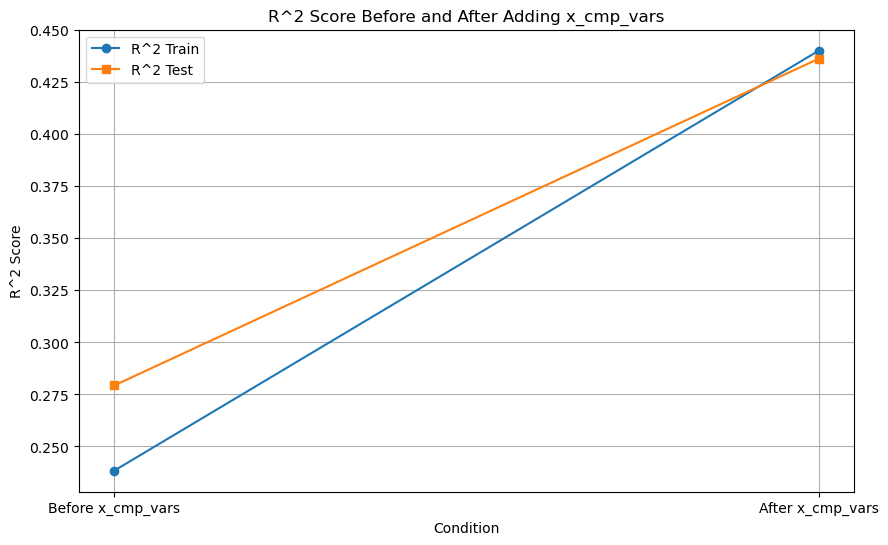

           Condition  R2_Train   R2_Test
0  Before x_cmp_vars  0.238395  0.279316
1   After x_cmp_vars  0.440094  0.436243


In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 가장 높은 테스트 R^2 점수를 가진 모델을 찾는다.
best_model_index = np.argmax(results_df['R2 Test'].values)
best_model_variables = x_variables[results_df.iloc[best_model_index]['X Variable Group']]
best_model_r2_test = results_df.iloc[best_model_index]['R2 Test']

# x_cmp_vars 추가 전의 R^2 점수
X_train, X_test, y_train, y_test = train_test_split(df[best_model_variables], df[y_vars[0]], test_size=0.25, random_state=42)
model = LinearRegression().fit(X_train, y_train)
r2_train_before = r2_score(y_train, model.predict(X_train))
r2_test_before = r2_score(y_test, model.predict(X_test))

# x_cmp_vars 추가 후의 R^2 점수
X_train, X_test, y_train, y_test = train_test_split(df[best_model_variables + x_cmp_vars], df[y_vars[0]], test_size=0.25, random_state=42)
model = LinearRegression().fit(X_train, y_train)
r2_train_after = r2_score(y_train, model.predict(X_train))
r2_test_after = r2_score(y_test, model.predict(X_test))

# R^2 점수 비교 데이터 프레임 생성
r2_comparison_df = pd.DataFrame({
    'Condition': ['Before x_cmp_vars', 'After x_cmp_vars'],
    'R2_Train': [r2_train_before, r2_train_after],
    'R2_Test': [r2_test_before, r2_test_after]
})

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(r2_comparison_df['Condition'], r2_comparison_df['R2_Train'], label='R^2 Train', marker='o')
plt.plot(r2_comparison_df['Condition'], r2_comparison_df['R2_Test'], label='R^2 Test', marker='s')
plt.xlabel('Condition')
plt.ylabel('R^2 Score')
plt.title('R^2 Score Before and After Adding x_cmp_vars')
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 비교 데이터 프레임 출력
print(r2_comparison_df)


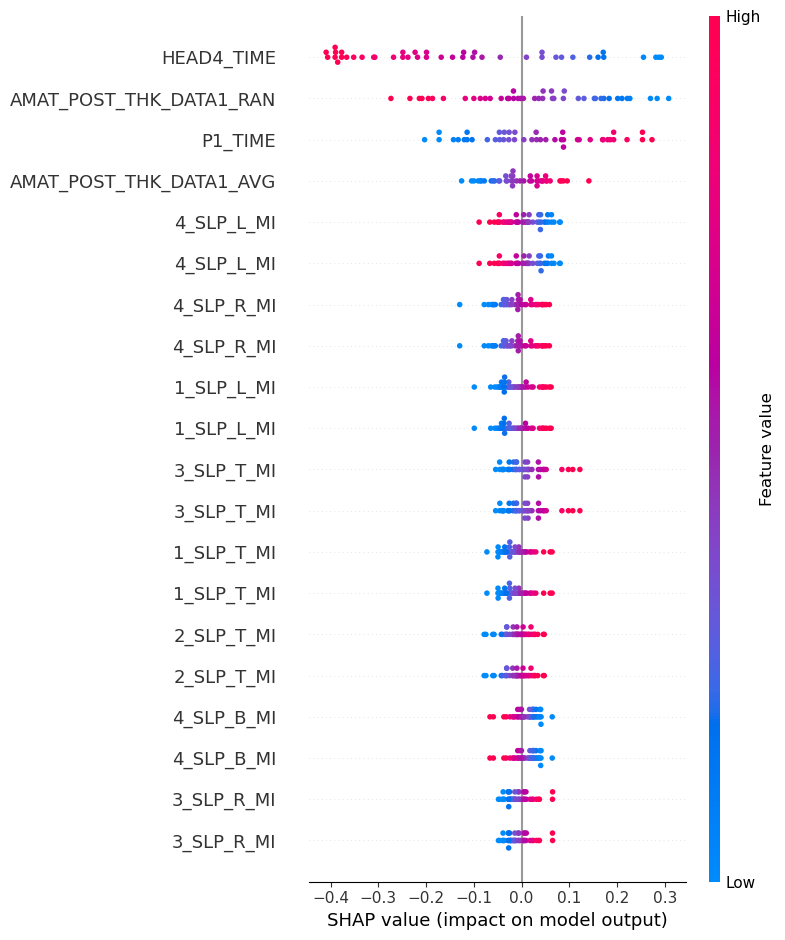

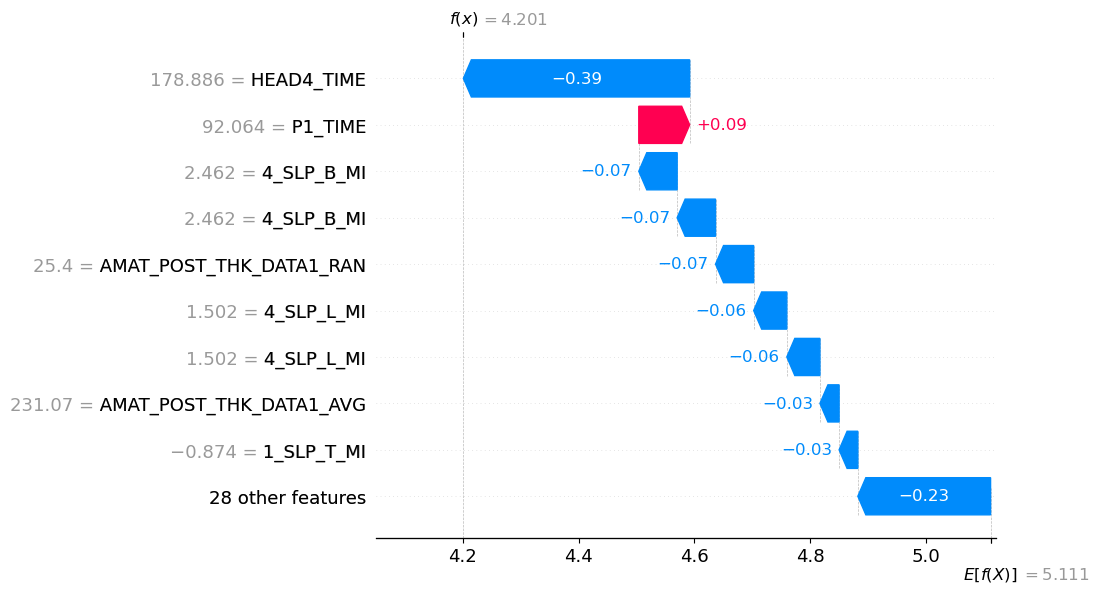

In [94]:
# 모델 학습
model = LinearRegression().fit(X_train, y_train)

# SHAP Explainer 생성 (Explainer 사용)
explainer = shap.Explainer(model, X_train)

# SHAP 값 계산
shap_values = explainer(X_test)  # X_test에 대한 SHAP 값을 얻음

# SHAP 요약 플롯 (summary plot) 그리기
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)

# 특정 샘플에 대한 SHAP 값 그리기 (예: 첫 번째 샘플)
shap.plots.waterfall(shap_values[0])  # 첫 번째 샘플에 대한 SHAP waterfall 플롯
# 특정 샘플에 대한 SHAP 값 시각화 (예를 들어 첫 번째 샘플)
shap.force_plot(shap_values.base_values, shap_values.values[0], X_train.iloc[0])

## 1-5. 차원 축소 진행 (Isomap) 후 실행

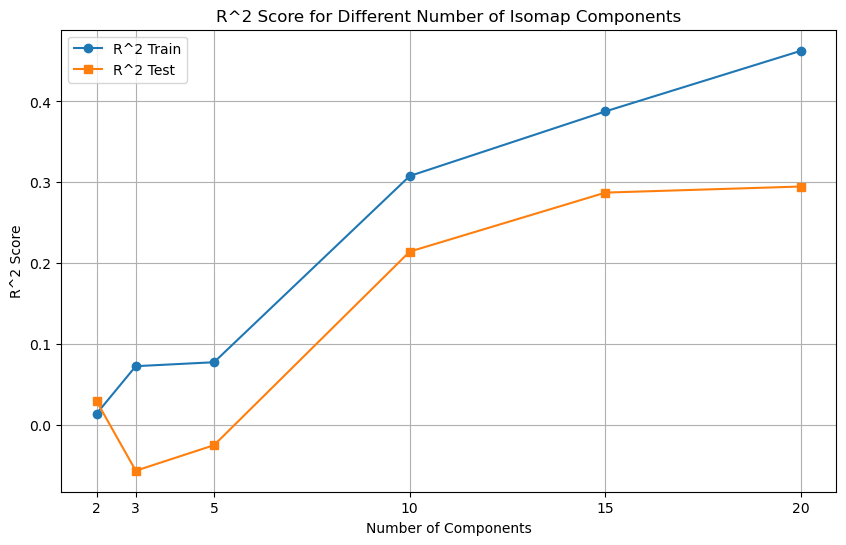

   n_components  R2_Train   R2_Test
0             2  0.013978  0.029255
1             3  0.072642 -0.056619
2             5  0.077527 -0.025023
3            10  0.307809  0.214321
4            15  0.387687  0.287265
5            20  0.462688  0.294784


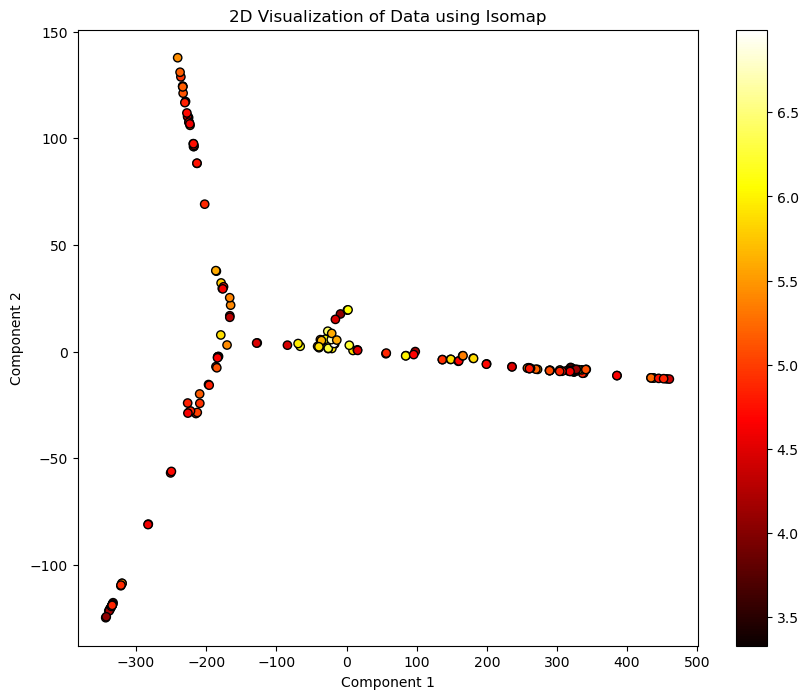

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap

# 데이터 준비 (df, x_cmp_vars, y_vars 등은 이미 정의되어 있다고 가정)

# 적절한 차원 수를 찾기 위한 그리드 탐색
n_neighbors = 7
n_components_grid = [2, 3, 5, 10, 15, 20]  # 탐색할 차원 수
r2_scores = []  # 각 차원에 대한 R^2 점수를 저장할 리스트

for n_components in n_components_grid:
    # Isomap 차원 축소 적용
    isomap = Isomap(n_components=n_components, n_neighbors = n_neighbors)
    X_isomap = isomap.fit_transform(df[best_model_variables + x_cmp_vars])

    # Isomap 적용된 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_isomap, df[y_vars[0]], test_size=0.25, random_state=42)

    # 모델 학습 및 R^2 점수 계산
    model_isomap = LinearRegression().fit(X_train, y_train)
    r2_train_isomap = r2_score(y_train, model_isomap.predict(X_train))
    r2_test_isomap = r2_score(y_test, model_isomap.predict(X_test))

    # 결과 저장
    r2_scores.append({
        'n_components': n_components,
        'R2_Train': r2_train_isomap,
        'R2_Test': r2_test_isomap
    })

# R^2 점수 비교 데이터 프레임 생성
r2_comparison_df = pd.DataFrame(r2_scores)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(r2_comparison_df['n_components'], r2_comparison_df['R2_Train'], label='R^2 Train', marker='o')
plt.plot(r2_comparison_df['n_components'], r2_comparison_df['R2_Test'], label='R^2 Test', marker='s')
plt.xlabel('Number of Components')
plt.ylabel('R^2 Score')
plt.title('R^2 Score for Different Number of Isomap Components')
plt.xticks(n_components_grid)  # x축에 표시될 값
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 비교 데이터 프레임 출력
print(r2_comparison_df)

# 차원 축소된 데이터 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y, cmap=plt.cm.hot, edgecolor='k')  # y는 타겟 변수
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Visualization of Data using Isomap')
plt.colorbar()
plt.show()


## 1-7. 차원축소 LLE 후 실행

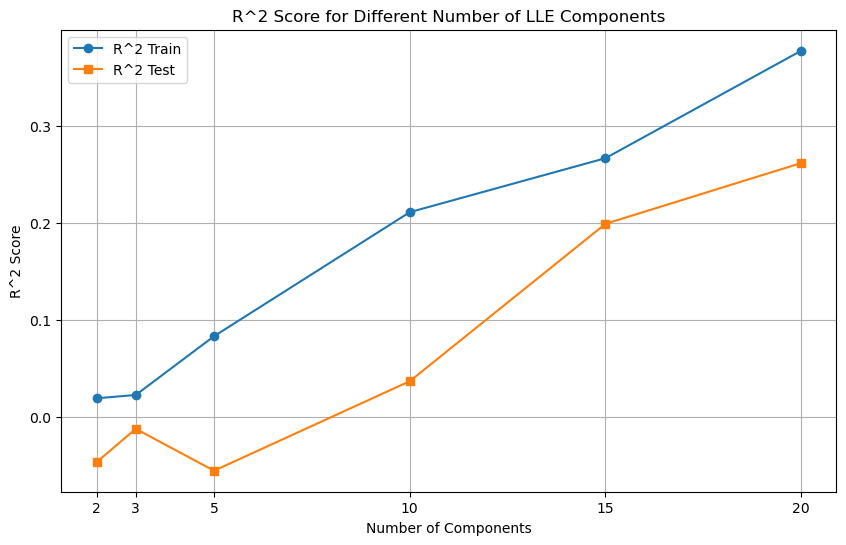

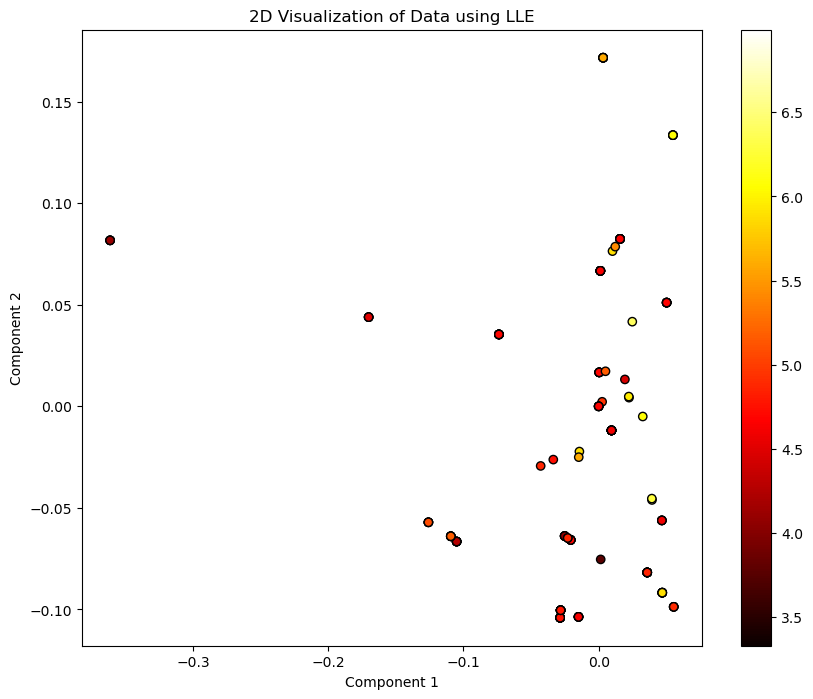

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding

# 데이터 준비 (df, x_cmp_vars, y_vars 등은 이미 정의되어 있다고 가정)

# 적절한 차원 수를 찾기 위한 그리드 탐색
n_neighbors = 3  # Isomap 경고 메시지를 기반으로 적절한 이웃의 수를 늘림
n_components_grid = [2, 3, 5, 10, 15, 20]  # 탐색할 차원 수
r2_scores = []  # 각 차원에 대한 R^2 점수를 저장할 리스트

for n_components in n_components_grid:
    # LLE 차원 축소 적용
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    X_lle = lle.fit_transform(df[best_model_variables + x_cmp_vars])

    # LLE 적용된 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_lle, df[y_vars[0]], test_size=0.25, random_state=42)

    # 모델 학습 및 R^2 점수 계산
    model_lle = LinearRegression().fit(X_train, y_train)
    r2_train_lle = r2_score(y_train, model_lle.predict(X_train))
    r2_test_lle = r2_score(y_test, model_lle.predict(X_test))

    # 결과 저장
    r2_scores.append({
        'n_components': n_components,
        'R2_Train': r2_train_lle,
        'R2_Test': r2_test_lle
    })

# R^2 점수 비교 데이터 프레임 생성
r2_comparison_df = pd.DataFrame(r2_scores)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(r2_comparison_df['n_components'], r2_comparison_df['R2_Train'], label='R^2 Train', marker='o')
plt.plot(r2_comparison_df['n_components'], r2_comparison_df['R2_Test'], label='R^2 Test', marker='s')
plt.xlabel('Number of Components')
plt.ylabel('R^2 Score')
plt.title('R^2 Score for Different Number of LLE Components')
plt.xticks(n_components_grid)
plt.legend()
plt.grid(True)
plt.show()

# 차원 축소된 데이터 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=df[y_vars[0]], cmap=plt.cm.hot, edgecolor='k')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Visualization of Data using LLE')
plt.colorbar()
plt.show()


## 2-1 Tree Model 기반 실행

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 37
[LightGBM] [Info] Start training from score 5.112580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

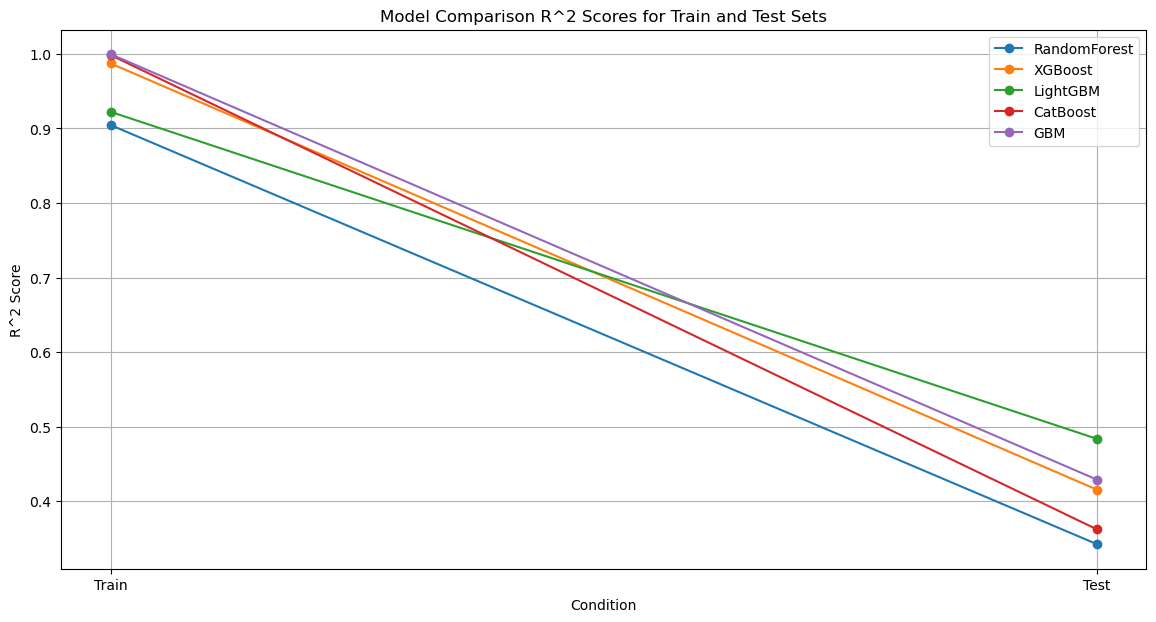

          Model  Train R2 Score  Test R2 Score
2      LightGBM        0.922253       0.483509
4           GBM        0.999605       0.428750
1       XGBoost        0.987223       0.415290
3      CatBoost        0.998411       0.362038
0  RandomForest        0.904518       0.342186


In [97]:
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# x_cmp_vars 추가 후의 데이터 준비
X = df[best_model_variables + x_cmp_vars]  # 가정: best_model_variables와 x_cmp_vars는 리스트 형태
y = df[y_vars[0]]  # 가정: y_vars는 타겟 변수의 이름을 포함하는 리스트

# 데이터 프레임 열 이름 중 중복되는 것이 있는지 확인하고 수정
columns = pd.Series(X.columns)
for dup in columns[columns.duplicated()].unique():
    columns[columns[columns == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(columns == dup))]
X.columns = columns

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 모델별로 Grid Search 수행
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cat.CatBoostRegressor(verbose=0),
    'GBM': GradientBoostingRegressor()
}

param_grid = {
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]},
    'LightGBM': {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]},
    'CatBoost': {'iterations': [100, 200], 'depth': [3, 5], 'learning_rate': [0.1, 0.01]},
    'GBM': {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]}
}

best_estimators = {}
r2_scores = {'Model': [], 'Train R2 Score': [], 'Test R2 Score': []}

for model_name in models:
    grid_search = GridSearchCV(models[model_name], param_grid[model_name], cv=5, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_

    # R^2 점수 계산
    r2_train = r2_score(y_train, best_estimators[model_name].predict(X_train))
    r2_test = r2_score(y_test, best_estimators[model_name].predict(X_test))

    # 결과 저장
    r2_scores['Model'].append(model_name)
    r2_scores['Train R2 Score'].append(r2_train)
    r2_scores['Test R2 Score'].append(r2_test)

# 결과를 데이터 프레임으로 변환
r2_scores = pd.DataFrame(r2_scores)
r2_scores_df = r2_scores.sort_values(by='Test R2 Score', ascending=False)


# 꺾은선 그래프 그리기
plt.figure(figsize=(14, 7))
for model in r2_scores['Model']:
    plt.plot(['Train', 'Test'], r2_scores_df[r2_scores_df['Model'] == model][['Train R2 Score', 'Test R2 Score']].values.flatten(), label=model, marker='o')
plt.xlabel('Condition')
plt.ylabel('R^2 Score')
plt.title('Model Comparison R^2 Scores for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

# R^2 점수 비교 데이터 프레임 출력
print(r2_scores_df)


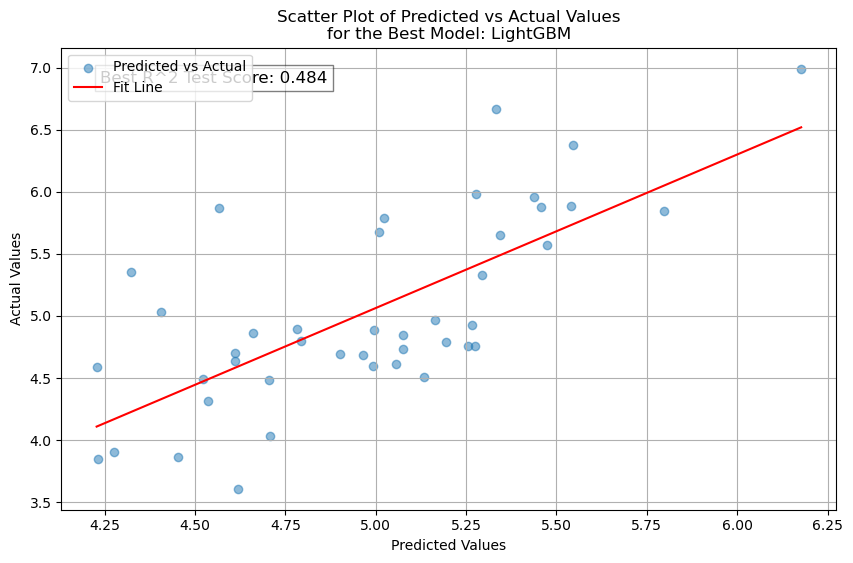

In [98]:
# 가장 높은 테스트 R^2 점수를 가진 모델 찾기
best_model_name = r2_scores_df.iloc[0]['Model']
best_model = best_estimators[best_model_name]

# 해당 모델을 사용하여 테스트 데이터에 대한 예측 수행
y_pred_test = best_model.predict(X_test)

# 예측값과 실제값 사이의 scatter plot 생성
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, y_test, alpha=0.5, label='Predicted vs Actual')
plt.title(f'Scatter Plot of Predicted vs Actual Values\nfor the Best Model: {best_model_name}')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# 최적의 선형 관계 선(fit line) 추가
slope, intercept = np.polyfit(y_pred_test, y_test, 1)
line_x = np.linspace(y_pred_test.min(), y_pred_test.max(), 100)
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'r-', label='Fit Line')

# 최고의 테스트 R^2 점수 표시
best_r2_test_score = r2_scores_df.iloc[0]['Test R2 Score']
plt.text(0.05, 0.95, f'Best R^2 Test Score: {best_r2_test_score:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.show()


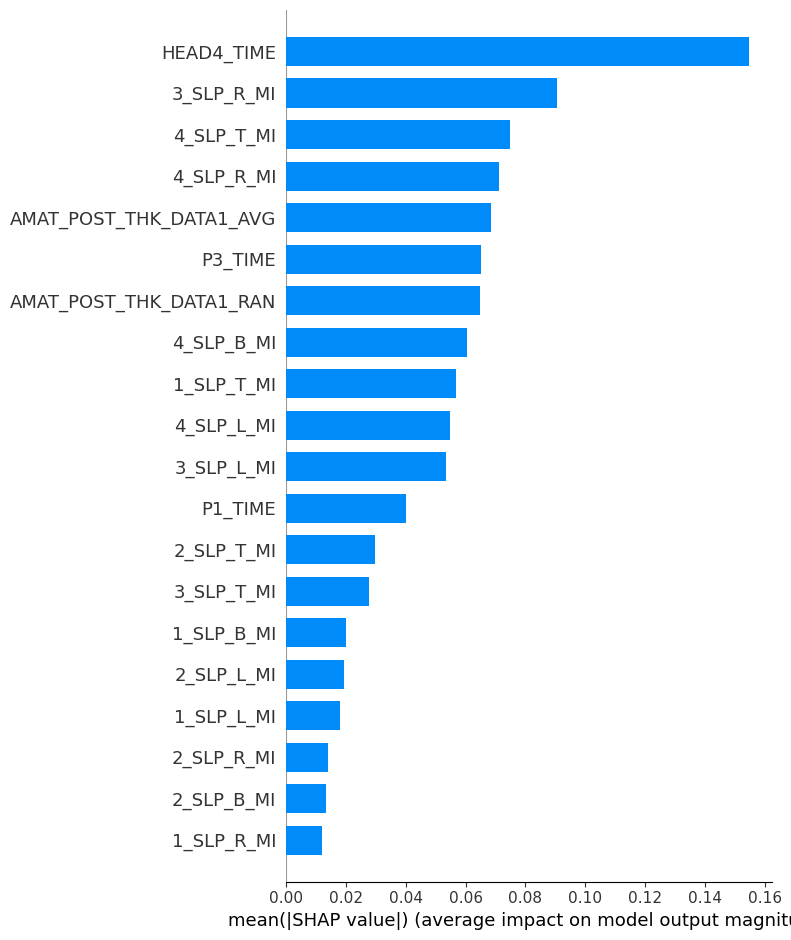

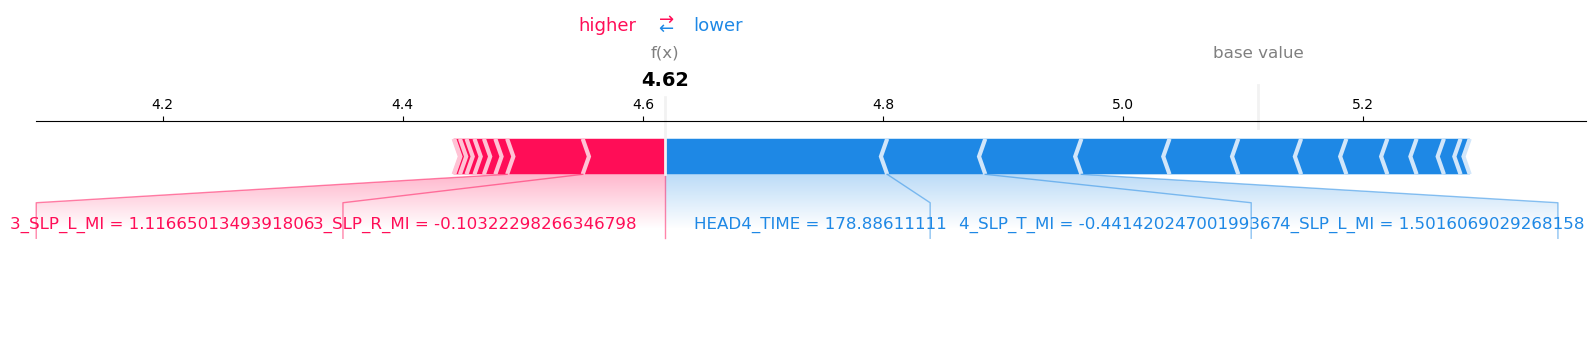

In [99]:
import shap

# 모델을 선택합니다. 예제로 LightGBM 모델을 사용
model = best_estimators['LightGBM']

# SHAP Explainer 초기화
explainer = shap.TreeExplainer(model)

# 훈련 데이터 또는 테스트 데이터에 대한 SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP 값으로 특정 샘플에 대한 기여도 시각화
# 예를 들어, 테스트 데이터의 첫 번째 샘플에 대한 기여도를 시각화하려면:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)


## 2-1-1. Tree Model 하이퍼 파라미터 조정 추가 실행 (데탑 소요시간 1분 24초)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 37
[LightGBM] [Info] Start training from score 5.112580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

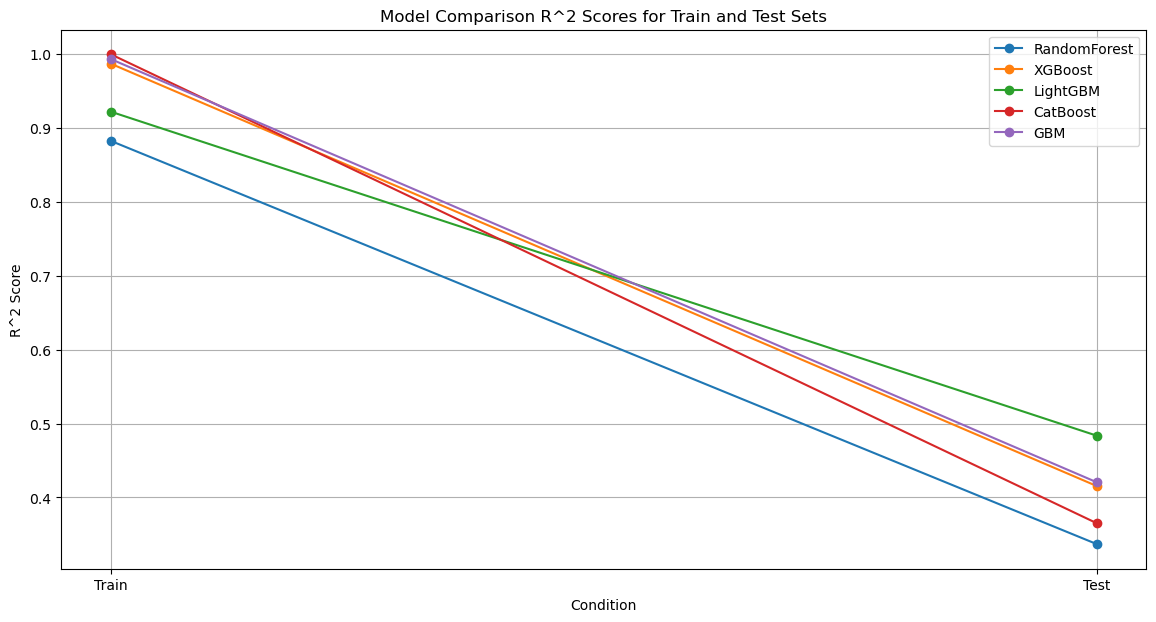

          Model  Train R2 Score  Test R2 Score
2      LightGBM        0.922253       0.483509
4           GBM        0.993451       0.420421
1       XGBoost        0.987223       0.415290
3      CatBoost        0.999999       0.364944
0  RandomForest        0.882742       0.336728


In [100]:
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# x_cmp_vars 추가 후의 데이터 준비
X = df[best_model_variables + x_cmp_vars]  # 가정: best_model_variables와 x_cmp_vars는 리스트 형태
y = df[y_vars[0]]  # 가정: y_vars는 타겟 변수의 이름을 포함하는 리스트

# 데이터 프레임 열 이름 중 중복되는 것이 있는지 확인하고 수정
columns = pd.Series(X.columns)
for dup in columns[columns.duplicated()].unique():
    columns[columns[columns == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(columns == dup))]
X.columns = columns

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 모델별로 Grid Search 수행
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cat.CatBoostRegressor(verbose=0),
    'GBM': GradientBoostingRegressor()
}

param_grid = {
    'RandomForest': {'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]},
    'LightGBM': {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]},
    'CatBoost': {'iterations': [100, 200, 500], 'depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]},
    'GBM': {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
}

best_estimators = {}
r2_scores = {'Model': [], 'Train R2 Score': [], 'Test R2 Score': []}

for model_name in models:
    grid_search = GridSearchCV(models[model_name], param_grid[model_name], cv=5, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_

    # R^2 점수 계산
    r2_train = r2_score(y_train, best_estimators[model_name].predict(X_train))
    r2_test = r2_score(y_test, best_estimators[model_name].predict(X_test))

    # 결과 저장
    r2_scores['Model'].append(model_name)
    r2_scores['Train R2 Score'].append(r2_train)
    r2_scores['Test R2 Score'].append(r2_test)

# 결과를 데이터 프레임으로 변환
r2_scores = pd.DataFrame(r2_scores)
r2_scores_df = r2_scores.sort_values(by='Test R2 Score', ascending=False)


# 꺾은선 그래프 그리기
plt.figure(figsize=(14, 7))
for model in r2_scores['Model']:
    plt.plot(['Train', 'Test'], r2_scores_df[r2_scores_df['Model'] == model][['Train R2 Score', 'Test R2 Score']].values.flatten(), label=model, marker='o')
plt.xlabel('Condition')
plt.ylabel('R^2 Score')
plt.title('Model Comparison R^2 Scores for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()


# R^2 점수 비교 데이터 프레임 출력
print(r2_scores_df)


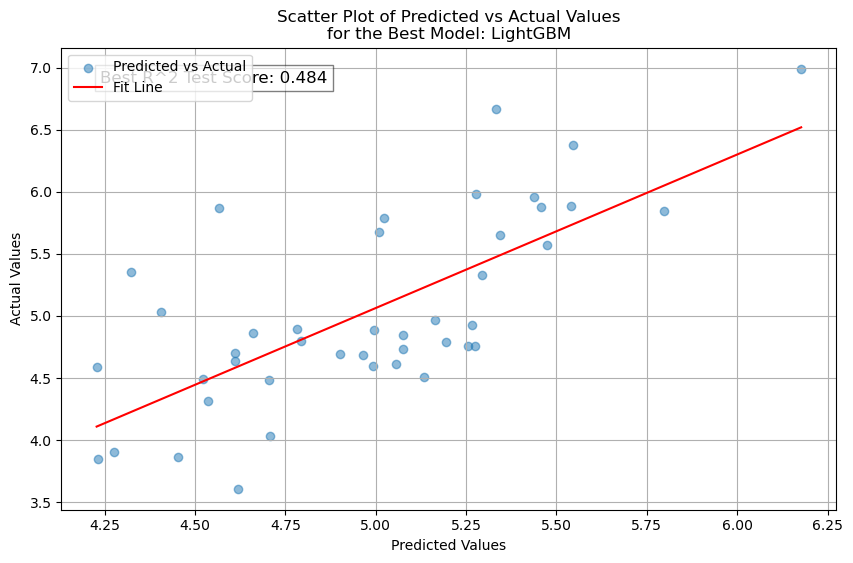

In [101]:
# 가장 높은 테스트 R^2 점수를 가진 모델 찾기
best_model_name = r2_scores_df.iloc[0]['Model']
best_model = best_estimators[best_model_name]

# 해당 모델을 사용하여 테스트 데이터에 대한 예측 수행
y_pred_test = best_model.predict(X_test)

# 예측값과 실제값 사이의 scatter plot 생성
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, y_test, alpha=0.5, label='Predicted vs Actual')
plt.title(f'Scatter Plot of Predicted vs Actual Values\nfor the Best Model: {best_model_name}')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# 최적의 선형 관계 선(fit line) 추가
slope, intercept = np.polyfit(y_pred_test, y_test, 1)
line_x = np.linspace(y_pred_test.min(), y_pred_test.max(), 100)
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'r-', label='Fit Line')

# 최고의 테스트 R^2 점수 표시
best_r2_test_score = r2_scores_df.iloc[0]['Test R2 Score']
plt.text(0.05, 0.95, f'Best R^2 Test Score: {best_r2_test_score:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.show()


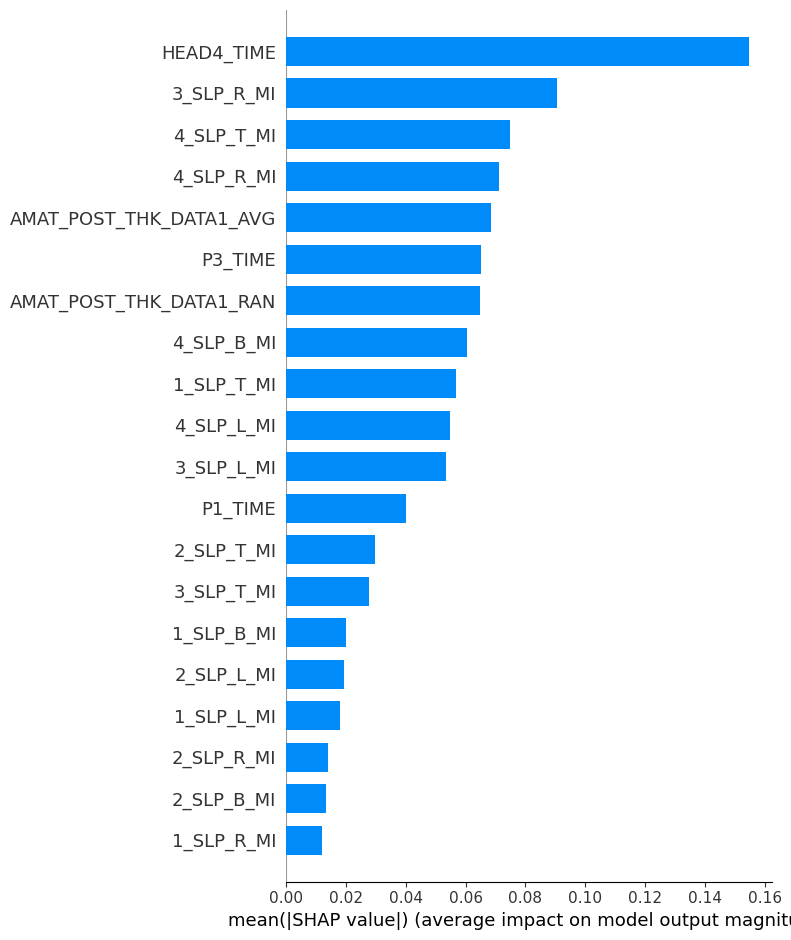

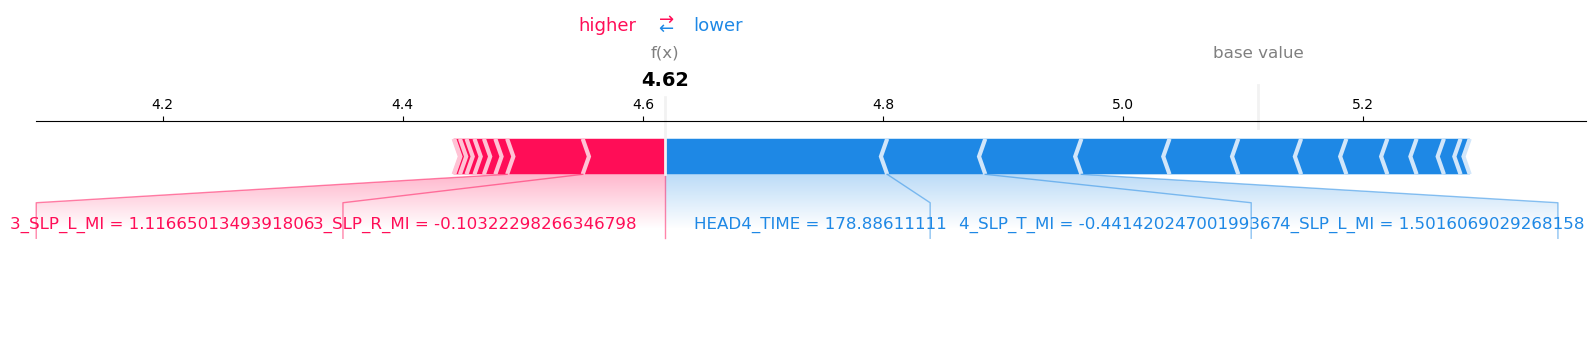

In [102]:
import shap

# 모델을 선택합니다. 예제로 LightGBM 모델을 사용
model = best_estimators['LightGBM']

# SHAP Explainer 초기화
explainer = shap.TreeExplainer(model)

# 훈련 데이터 또는 테스트 데이터에 대한 SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP 값으로 특정 샘플에 대한 기여도 시각화
# 예를 들어, 테스트 데이터의 첫 번째 샘플에 대한 기여도를 시각화하려면:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)


## 2-1-2. Tree Model 하이퍼 파라미터 조정 추가 실행 (데탑에서 소요시간 20분)


540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
229 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kimpd\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kimpd\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\kimpd\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\kimpd\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidPara

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 37
[LightGBM] [Info] Start training from score 5.112580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

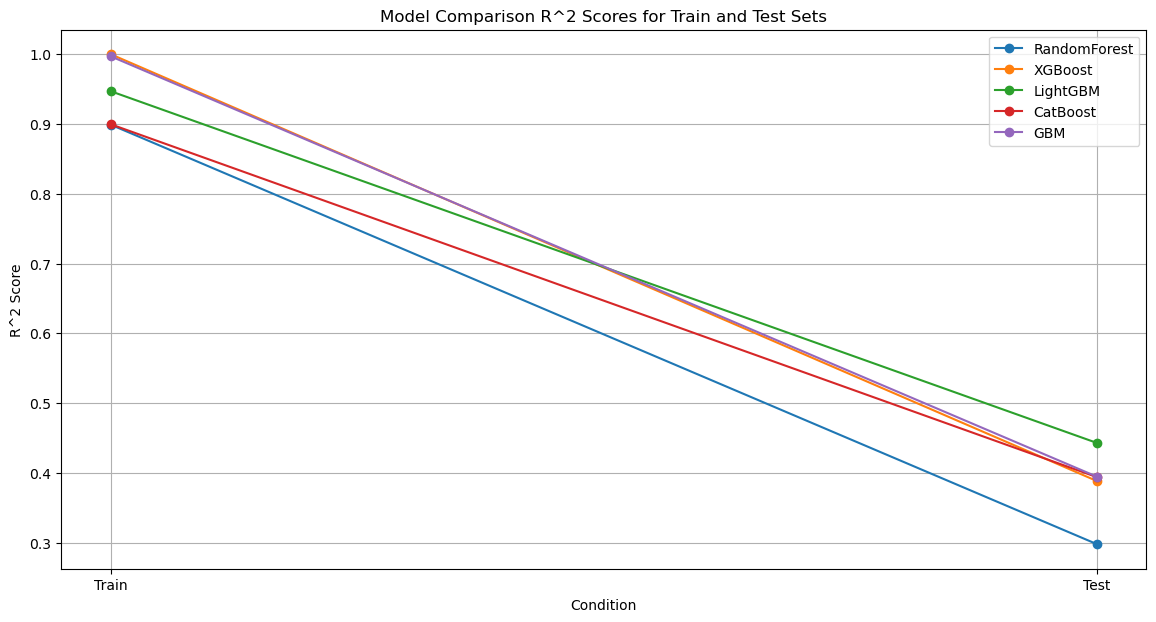

          Model  Train R2 Score  Test R2 Score
2      LightGBM        0.946980       0.442823
4           GBM        0.996990       0.394435
3      CatBoost        0.899641       0.393822
1       XGBoost        0.999999       0.388198
0  RandomForest        0.898996       0.297745


In [30]:
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# x_cmp_vars 추가 후의 데이터 준비
X = df[best_model_variables + x_cmp_vars]  # 가정: best_model_variables와 x_cmp_vars는 리스트 형태
y = df[y_vars[0]]  # 가정: y_vars는 타겟 변수의 이름을 포함하는 리스트

# 데이터 프레임 열 이름 중 중복되는 것이 있는지 확인하고 수정
columns = pd.Series(X.columns)
for dup in columns[columns.duplicated()].unique():
    columns[columns[columns == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(columns == dup))]
X.columns = columns

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 모델별로 Grid Search 수행
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cat.CatBoostRegressor(verbose=0),
    'GBM': GradientBoostingRegressor()
}

param_grid = {
    'RandomForest': {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.05, 0.01],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.1, 0.05, 0.01],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'CatBoost': {
        'iterations': [100, 200, 500, 1000],
        'depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.05, 0.01],
        'bagging_temperature': [0, 1, 10]
    },
    'GBM': {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.05, 0.01],
        'subsample': [0.8, 0.9, 1.0]
    }
}


best_estimators = {}
r2_scores = {'Model': [], 'Train R2 Score': [], 'Test R2 Score': []}

for model_name in models:
    grid_search = GridSearchCV(models[model_name], param_grid[model_name], cv=5, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_

    # R^2 점수 계산
    r2_train = r2_score(y_train, best_estimators[model_name].predict(X_train))
    r2_test = r2_score(y_test, best_estimators[model_name].predict(X_test))

    # 결과 저장
    r2_scores['Model'].append(model_name)
    r2_scores['Train R2 Score'].append(r2_train)
    r2_scores['Test R2 Score'].append(r2_test)

# 결과를 데이터 프레임으로 변환
r2_scores = pd.DataFrame(r2_scores)
r2_scores_df = r2_scores.sort_values(by='Test R2 Score', ascending=False)


# 꺾은선 그래프 그리기
plt.figure(figsize=(14, 7))
for model in r2_scores['Model']:
    plt.plot(['Train', 'Test'], r2_scores_df[r2_scores_df['Model'] == model][['Train R2 Score', 'Test R2 Score']].values.flatten(), label=model, marker='o')
plt.xlabel('Condition')
plt.ylabel('R^2 Score')
plt.title('Model Comparison R^2 Scores for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()


# R^2 점수 비교 데이터 프레임 출력
print(r2_scores_df)


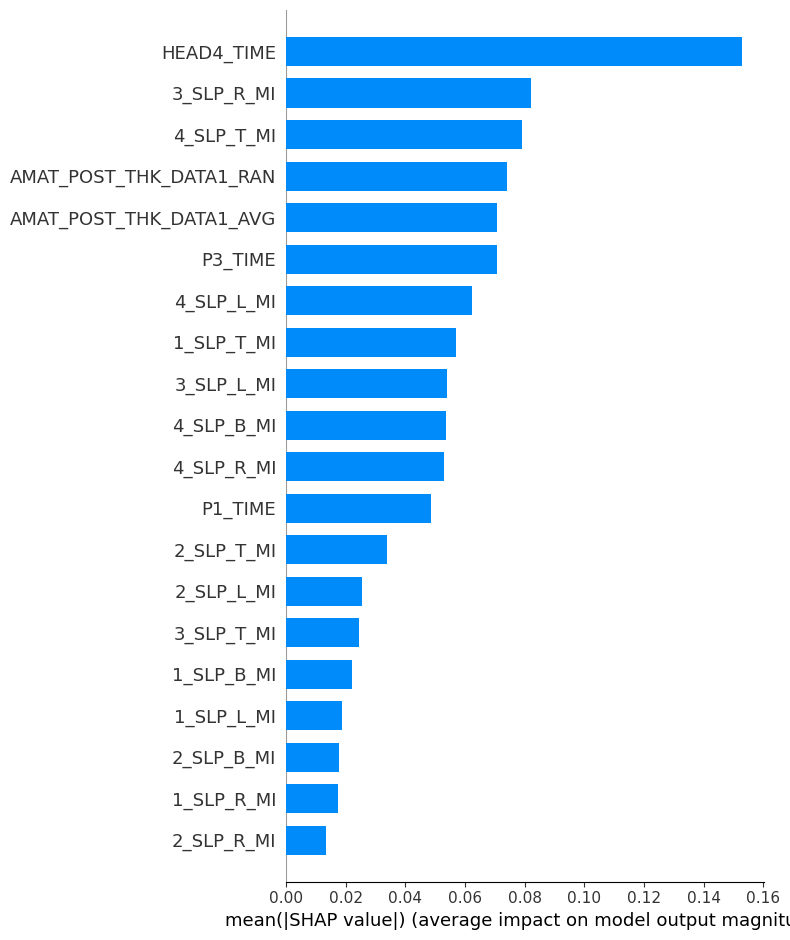

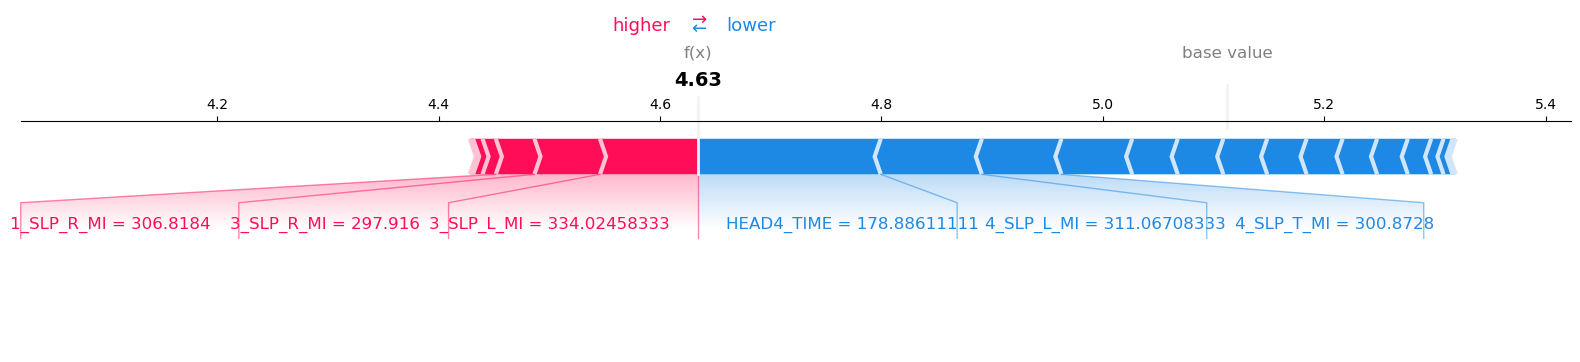

In [31]:
import shap

# 모델을 선택합니다. 예제로 LightGBM 모델을 사용
model = best_estimators['LightGBM']

# SHAP Explainer 초기화
explainer = shap.TreeExplainer(model)

# 훈련 데이터 또는 테스트 데이터에 대한 SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP 값으로 특정 샘플에 대한 기여도 시각화
# 예를 들어, 테스트 데이터의 첫 번째 샘플에 대한 기여도를 시각화하려면:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)


## 3-1 Tabnet 기반 모델 예측 실행

Device used : cpu


epoch 0  | loss: 35.14536| eval_mse: 25.6038 |  0:00:00s
epoch 1  | loss: 29.38899| eval_mse: 22.32127|  0:00:00s
epoch 2  | loss: 23.91891| eval_mse: 19.31669|  0:00:00s
epoch 3  | loss: 20.72159| eval_mse: 16.19084|  0:00:00s
epoch 4  | loss: 17.68926| eval_mse: 14.10294|  0:00:00s
epoch 5  | loss: 15.30073| eval_mse: 13.07503|  0:00:00s
epoch 6  | loss: 13.02089| eval_mse: 11.68382|  0:00:00s
epoch 7  | loss: 11.62529| eval_mse: 10.73529|  0:00:00s
epoch 8  | loss: 9.63875 | eval_mse: 9.49044 |  0:00:00s
epoch 9  | loss: 6.90354 | eval_mse: 8.28417 |  0:00:00s
epoch 10 | loss: 6.42836 | eval_mse: 7.06274 |  0:00:00s
epoch 11 | loss: 5.09868 | eval_mse: 5.98155 |  0:00:00s
epoch 12 | loss: 4.30934 | eval_mse: 4.98795 |  0:00:00s
epoch 13 | loss: 3.49033 | eval_mse: 4.0951  |  0:00:00s
epoch 14 | loss: 3.12699 | eval_mse: 3.35601 |  0:00:00s
epoch 15 | loss: 2.35327 | eval_mse: 2.82163 |  0:00:00s
epoch 16 | loss: 2.45041 | eval_mse: 2.45348 |  0:00:00s
epoch 17 | loss: 1.80257 | eval

Best weights from best epoch are automatically used!


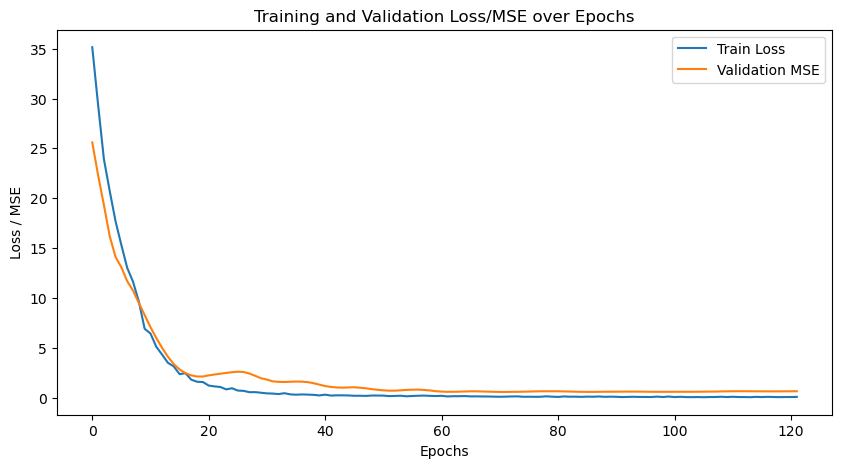

In [103]:
# !pip install pytorch-tabnet

import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 표준화
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# y_train과 y_test를 2D 배열로 변환
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# TabNet 모델 생성 및 학습 코드
tabnet_model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                               optimizer_params=dict(lr=2e-2),
                               scheduler_params={"step_size":10, "gamma":0.9},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               mask_type='entmax') # "sparsemax"

tabnet_model.fit(
    X_train, y_train_reshaped,
    eval_set=[(X_test, y_test_reshaped)],
    eval_name=['eval'],
    eval_metric=['mse'],
    max_epochs=1000, patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0, drop_last=False
)

# 테스트 데이터에 대한 예측 및 R^2 점수 계산
predictions = tabnet_model.predict(X_test)
test_r2_score = r2_score(y_test_reshaped, predictions)
print("Test R^2 Score:", test_r2_score)

# 훈련 및 테스트 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(tabnet_model.history['loss'], label='Train Loss')
plt.plot(tabnet_model.history['eval_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss / MSE')
plt.title('Training and Validation Loss/MSE over Epochs')
plt.legend()
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

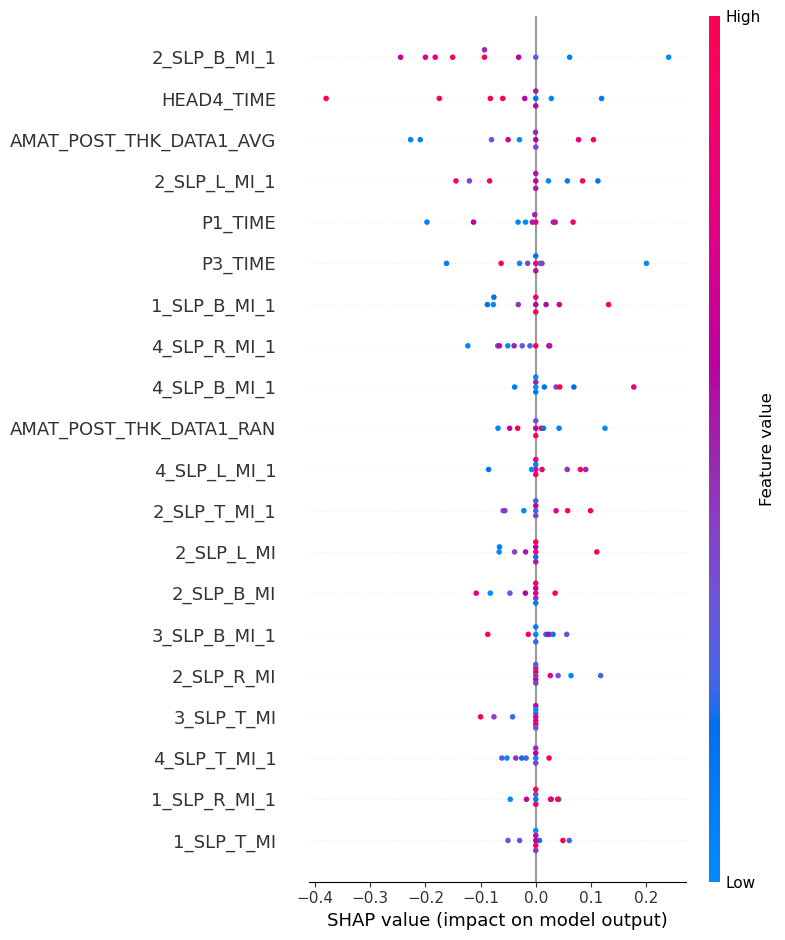

In [104]:
import shap

# 모델의 예측 함수를 정의합니다.
# TabNet의 경우 입력 데이터로 numpy 배열을 받아들이므로, 예측 함수도 이에 맞게 정의합니다.
def tabnet_predict(input_data):
    return tabnet_model.predict(input_data).flatten()

# KernelExplainer를 사용하여 SHAP 값을 계산합니다.
explainer = shap.KernelExplainer(model=tabnet_predict, data=X_train[:100], link="identity")

# 테스트 데이터의 일부에 대해 SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X=X_test[:10], nsamples=100)

# SHAP 요약 플롯을 그립니다.
shap.summary_plot(shap_values=shap_values, features=X_test[:10], feature_names=X.columns.tolist())


Device used : cpu


epoch 0  | loss: 22.11802| eval_mse: 10.87014|  0:00:00s
epoch 1  | loss: 6.78718 | eval_mse: 3.38686 |  0:00:00s
epoch 2  | loss: 2.93819 | eval_mse: 2.8034  |  0:00:00s
epoch 3  | loss: 1.76263 | eval_mse: 2.48687 |  0:00:00s
epoch 4  | loss: 1.50711 | eval_mse: 1.77396 |  0:00:00s
epoch 5  | loss: 1.09847 | eval_mse: 1.54428 |  0:00:00s
epoch 6  | loss: 0.87369 | eval_mse: 1.06661 |  0:00:01s
epoch 7  | loss: 0.82101 | eval_mse: 0.88345 |  0:00:01s
epoch 8  | loss: 0.5749  | eval_mse: 1.05935 |  0:00:01s
epoch 9  | loss: 0.74762 | eval_mse: 1.19379 |  0:00:01s
epoch 10 | loss: 0.70178 | eval_mse: 0.94258 |  0:00:01s
epoch 11 | loss: 0.58947 | eval_mse: 0.95161 |  0:00:01s
epoch 12 | loss: 0.54743 | eval_mse: 0.7875  |  0:00:01s
epoch 13 | loss: 0.42195 | eval_mse: 0.51497 |  0:00:02s
epoch 14 | loss: 0.4082  | eval_mse: 0.43774 |  0:00:02s
epoch 15 | loss: 0.51547 | eval_mse: 0.55222 |  0:00:02s
epoch 16 | loss: 0.47038 | eval_mse: 0.55782 |  0:00:02s
epoch 17 | loss: 0.48597 | eval

Best weights from best epoch are automatically used!


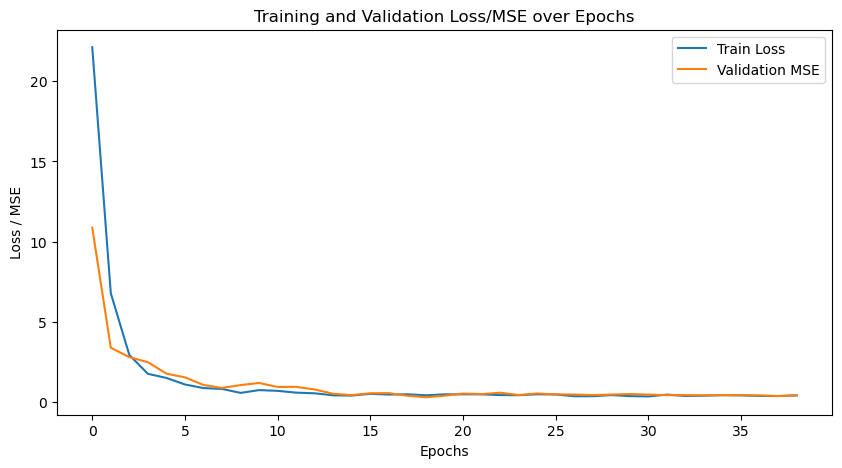

In [105]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

tabnet_model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                               optimizer_params=dict(lr=2e-2, weight_decay=1e-4), # L2 정규화 적용
                               scheduler_params={"step_size":10, "gamma":0.9},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               mask_type='entmax',
                               n_d=8, n_a=8, # 모델 복잡도 감소
                               )

tabnet_model.fit(
    X_train, y_train_reshaped,
    eval_set=[(X_test, y_test_reshaped)],
    eval_name=['eval'],
    eval_metric=['mse'],
    max_epochs=1000,
    patience=20, # 조기 종료 매개변수 조정
    batch_size=16, # 배치 크기 감소
    virtual_batch_size=8,
    num_workers=0,
    drop_last=False
)


# 테스트 데이터에 대한 예측 및 R^2 점수 계산
predictions = tabnet_model.predict(X_test)
test_r2_score = r2_score(y_test_reshaped, predictions)
print("Test R^2 Score:", test_r2_score)

# 훈련 및 테스트 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(tabnet_model.history['loss'], label='Train Loss')
plt.plot(tabnet_model.history['eval_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss / MSE')
plt.title('Training and Validation Loss/MSE over Epochs')
plt.legend()
plt.show()



  0%|          | 0/10 [00:00<?, ?it/s]

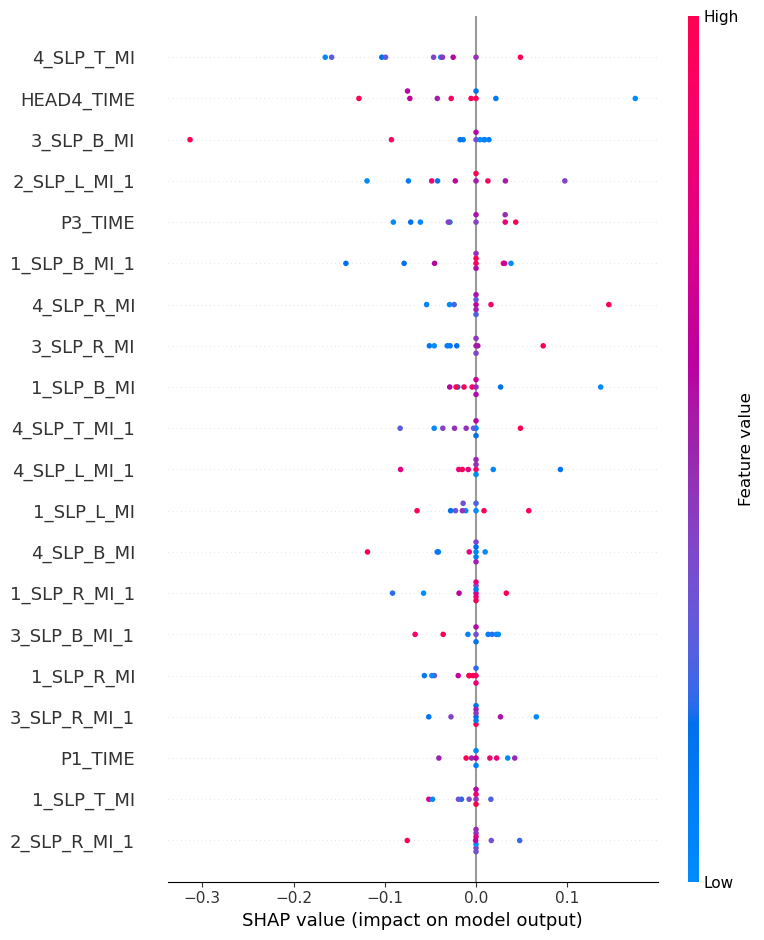

In [106]:
import shap

# 모델의 예측 함수를 정의합니다.
# TabNet의 경우 입력 데이터로 numpy 배열을 받아들이므로, 예측 함수도 이에 맞게 정의합니다.
def tabnet_predict(input_data):
    return tabnet_model.predict(input_data).flatten()

# KernelExplainer를 사용하여 SHAP 값을 계산합니다.
explainer = shap.KernelExplainer(model=tabnet_predict, data=X_train[:100], link="identity")

# 테스트 데이터의 일부에 대해 SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X=X_test[:10], nsamples=100)

# SHAP 요약 플롯을 그립니다.
shap.summary_plot(shap_values=shap_values, features=X_test[:10], feature_names=X.columns.tolist())


In [107]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# 하이퍼파라미터 조정
tabnet_params = {
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=1e-2, weight_decay=1e-3),
    'scheduler_params': {'step_size':20, 'gamma':0.95},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'mask_type': 'entmax', # "sparsemax"
    'n_d': 16,
    'n_a': 16,
}

tabnet_model = TabNetRegressor(**tabnet_params)

tabnet_model.fit(
    X_train, y_train_reshaped,
    eval_set=[(X_test, y_test_reshaped)],
    eval_name=['eval'],
    eval_metric=['mse'],
    max_epochs=200,
    patience=30,
    batch_size=64,
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

# 모델 성능 평가
predictions = tabnet_model.predict(X_test)
test_r2_score = r2_score(y_test_reshaped, predictions)
print("Test R^2 Score:", test_r2_score)


Device used : cpu


epoch 0  | loss: 29.14693| eval_mse: 18.98974|  0:00:00s
epoch 1  | loss: 18.68458| eval_mse: 14.43872|  0:00:00s
epoch 2  | loss: 11.91804| eval_mse: 11.19615|  0:00:00s
epoch 3  | loss: 7.6222  | eval_mse: 7.73583 |  0:00:00s
epoch 4  | loss: 4.97269 | eval_mse: 5.8536  |  0:00:00s
epoch 5  | loss: 3.79828 | eval_mse: 4.24461 |  0:00:00s
epoch 6  | loss: 3.10812 | eval_mse: 3.38439 |  0:00:00s
epoch 7  | loss: 2.25445 | eval_mse: 3.1367  |  0:00:00s
epoch 8  | loss: 1.90778 | eval_mse: 3.29401 |  0:00:00s
epoch 9  | loss: 1.46682 | eval_mse: 3.32881 |  0:00:00s
epoch 10 | loss: 1.506   | eval_mse: 3.05965 |  0:00:00s
epoch 11 | loss: 1.23505 | eval_mse: 2.77469 |  0:00:00s
epoch 12 | loss: 0.96657 | eval_mse: 2.46517 |  0:00:00s
epoch 13 | loss: 1.11446 | eval_mse: 2.14962 |  0:00:00s
epoch 14 | loss: 0.93029 | eval_mse: 1.97313 |  0:00:00s
epoch 15 | loss: 0.83739 | eval_mse: 1.7696  |  0:00:00s
epoch 16 | loss: 0.67813 | eval_mse: 1.6302  |  0:00:00s
epoch 17 | loss: 0.63714 | eval

Best weights from best epoch are automatically used!


  0%|          | 0/10 [00:00<?, ?it/s]

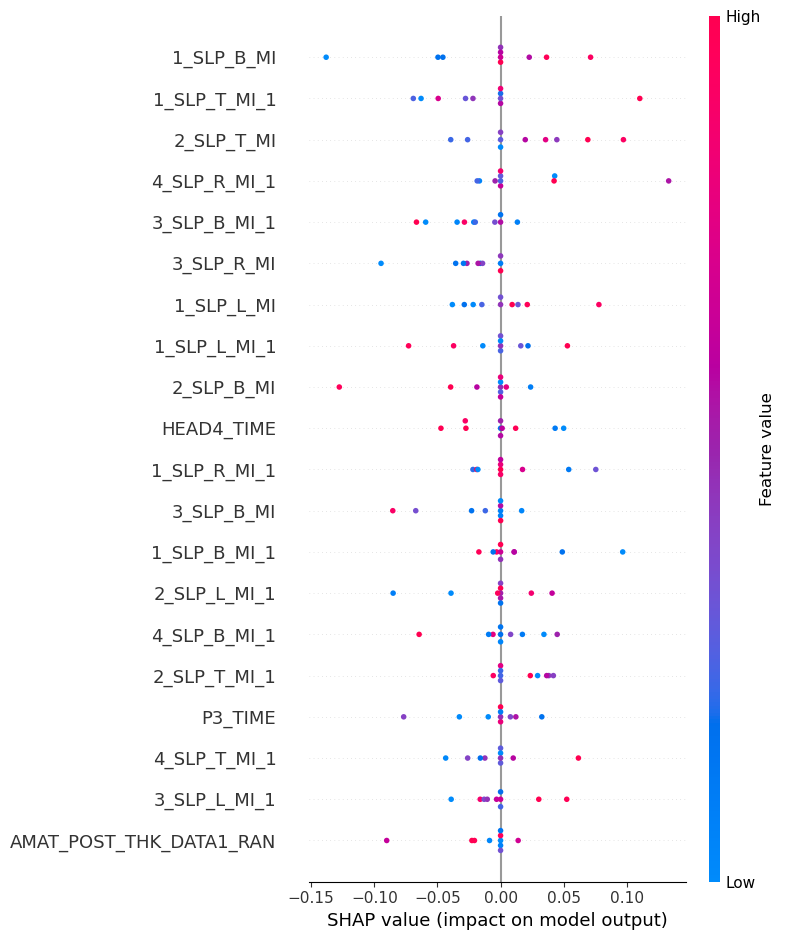

In [108]:
import shap

# 모델의 예측 함수를 정의합니다.
# TabNet의 경우 입력 데이터로 numpy 배열을 받아들이므로, 예측 함수도 이에 맞게 정의합니다.
def tabnet_predict(input_data):
    return tabnet_model.predict(input_data).flatten()

# KernelExplainer를 사용하여 SHAP 값을 계산합니다.
explainer = shap.KernelExplainer(model=tabnet_predict, data=X_train[:100], link="identity")

# 테스트 데이터의 일부에 대해 SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X=X_test[:10], nsamples=100)

# SHAP 요약 플롯을 그립니다.
shap.summary_plot(shap_values=shap_values, features=X_test[:10], feature_names=X.columns.tolist())
